# Solving the combined classification and regression task

Problem

The calorimeter has a multiple showers where the energy is distributed through multiple blocks. The shower centers can be anywhere in the calorimeter ( –1000 < x,y < +1000 ) and will never be outside of that. Energy from the shower that falls outside of the calorimeter however, is lost. 

In the example, there are 2 showers. 

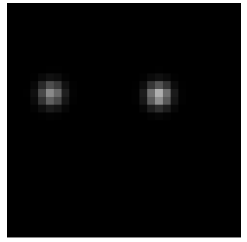

Each shower has three values: shower amplitude, x-coordinate of shower center, y-coordinate of shower center.
So in case of 5 showers we have (amp1, X1, Y1, amp2, X2, Y2, amp3, X3, Y3, amp4, X4, Y4, amp5, X5, Y5). For events with fewer than 5 showers, the parameters are set to –1. So for example, for a 1 shower event the labels would be (amp1, X1, Y1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1).

Noise hits can appear on the images.

The data comes as PNG files (8-bit greyscale) for each of the events that are stored in the relevant directory such as "train_images". For this set, there is an CSV file named "train_images.csv". The first column is just the PNG file name and the next 9 columns represent the amplitude, x, y of the three showers (in that order) in the same units as are used for the labels. 
For events with fewer than 5 showers, the amplitudes for the missing showers should be set to a value < 0. Any showers with an amplitude less than 0 will be considered to mean “no shower”. 


The solution to this problem will consist of a single CSV file with 15 columns containing the parameters (amp, X, Y) for each of 5 showers in the event for the events in the judge.csv or judge_images.csv file. Each row in the output should correspond to the events in the judge data set, in the same order of the events there. 

Our input is represented as a set of images, that's why CNN was chosen as a model. We need to get the predictions for the number of showers (from 0 to 5), so we face with the classification task. At the same time we have to predict continuous values, so it's a regression task as well. 

Firstly let's import all necessary python libraries

In [2]:
import os
from os import listdir
from os.path import isfile, join
import glob
import time
import pandas as pd
import numpy as np
from numpy import unravel_index
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import Sequential, load_model, Model
from keras.layers import Input, Dense, Activation, Flatten, Dropout, BatchNormalization, Reshape
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
import matplotlib.pyplot as plt

The helping function for the counting the number of showers.

In [3]:
def check_output(row):
    count_minus1 = 0
    for r in row:
        if r==-1:
            count_minus1 += 1
    
    if count_minus1 == 3:
        return 4
    elif count_minus1 == 6:
        return 3
    elif count_minus1 == 9:
        return 2
    elif count_minus1 == 12:
        return 1
    elif count_minus1 == 15:
        return 0
    
    else:
        return 5       

Get input from csv-file and create Pandas DataFrames with labels for train, test and  judge data

In [4]:
source = "https://userweb.jlab.org/~tbritton/Hackathon2021_DataSets/Problem5/"

# train dataset
df_train = pd.read_csv(
    os.path.join(source,"train_images.csv"), 
    na_values=['NA', '?'], header=None)

mapping = {df_train.columns[0]: 'filename', df_train.columns[1]: 'filenameClean',
           df_train.columns[2]: 'amp1', df_train.columns[3]: 'X1', df_train.columns[4]: 'Y1',
           df_train.columns[5]: 'amp2', df_train.columns[6]: 'X2', df_train.columns[7]: 'Y2',
           df_train.columns[8]: 'amp3', df_train.columns[9]: 'X3', df_train.columns[10]: 'Y3',
           df_train.columns[11]: 'amp4', df_train.columns[12]: 'X4', df_train.columns[13]: 'Y4',
           df_train.columns[14]: 'amp5', df_train.columns[15]: 'X5', df_train.columns[16]: 'Y5',
           df_train.columns[17]: 'amp6', df_train.columns[18]: 'X6', df_train.columns[19]: 'Y6'}
df_train = df_train.rename(columns=mapping)

df_train = df_train.iloc[:,:-3]

df_train['filename'] = df_train['filename'].str.replace(r'train_images/', '', regex=True)
df_train['filename'] = df_train['filename'].str.replace(r'.png', '',regex=True)+'.png'

df_train['filenameClean'] = df_train['filenameClean'].str.replace(r'train_images/clean_', '', regex=True)
df_train['filenameClean'] = df_train['filenameClean'].str.replace(r'.png', '',regex=True)+'.png'
df_train['number of showers'] = df_train.apply(check_output, axis=1).astype(str)

# test dataset
df_test = pd.read_csv(
    os.path.join(source,"test_images.csv"), 
    na_values=['NA', '?'], header=None)

mapping = {df_test.columns[0]: 'filename', df_test.columns[1]: 'filenameClean',
           df_test.columns[2]: 'amp1', df_test.columns[3]: 'X1', df_test.columns[4]: 'Y1',
           df_test.columns[5]: 'amp2', df_test.columns[6]: 'X2', df_test.columns[7]: 'Y2',
           df_test.columns[8]: 'amp3', df_test.columns[9]: 'X3', df_test.columns[10]: 'Y3',
           df_test.columns[11]: 'amp4', df_test.columns[12]: 'X4', df_test.columns[13]: 'Y4',
           df_test.columns[14]: 'amp5', df_test.columns[15]: 'X5', df_test.columns[16]: 'Y5',
           df_test.columns[17]: 'amp6', df_test.columns[18]: 'X6', df_test.columns[19]: 'Y6'}
df_test = df_test.rename(columns=mapping)

df_test = df_test.iloc[:,:-3]

df_test['filename'] = df_test['filename'].str.replace(r'test_images/', '', regex=True)
df_test['filename'] = df_test['filename'].str.replace(r'.png', '',regex=True)+'.png'

df_test['filenameClean'] = df_test['filenameClean'].str.replace(r'test_images/clean_', '', regex=True)
df_test['filenameClean'] = df_test['filenameClean'].str.replace(r'.png', '',regex=True)+'.png'
df_test['number of showers'] = df_test.apply(check_output, axis=1).astype(str)

# judge dataset
df_judge = pd.read_csv(
    os.path.join(source,"judge_images.csv"), 
    na_values=['NA', '?'], header=None)

mapping = {df_judge.columns[0]: 'filename'}
df_judge = df_judge.rename(columns=mapping)
df_judge['filename'] = df_judge['filename'].str.replace(r'judge_images/', '', regex=True)
df_judge['filename'] = df_judge['filename'].str.replace(r'.png', '',regex=True)+'.png'

print(f"Training size: {len(df_train)}")
print(f"Test size: {len(df_test)}")

df_judge.tail(10)

Training size: 10000
Test size: 2000


filename
1990  event001990.png
1991  event001991.png
1992  event001992.png
1993  event001993.png
1994  event001994.png
1995  event001995.png
1996  event001996.png
1997  event001997.png
1998  event001998.png
1999  event001999.png

Create dataframes for noisy and clean data

In [5]:
# noisy train dataset
df_noisy = pd.read_csv(
    os.path.join(source,"train.csv"), 
    na_values=['NA', '?'], header=None)
df_noisy = df_noisy.iloc[:,0:900]
df_noisy

0       1       2       3       4       5       6       7       8    \
0     0.00  0.0000  0.0000  0.0000  0.0669  0.0000  0.0000  0.0000  0.0000   
1     0.00  0.0500  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.2065   
2     0.00  0.0000  0.0000  0.1735  0.0000  0.0000  0.0000  0.0000  0.0000   
3     0.05  0.0000  0.0847  0.2630  0.0000  0.0000  0.0000  0.0000  0.0699   
4     0.00  0.0000  0.1445  0.0000  0.1022  0.1413  0.0000  0.1703  0.0000   
...    ...     ...     ...     ...     ...     ...     ...     ...     ...   
9995  0.00  0.0000  0.0000  0.0000  0.0500  0.0000  0.0000  0.0000  0.0000   
9996  0.00  0.2355  0.0500  0.1338  0.0000  0.0000  0.1751  0.0000  0.0000   
9997  0.00  0.0000  0.0000  0.0000  0.1630  0.0000  0.0807  0.0000  0.0000   
9998  0.00  0.0000  0.0000  0.0965  0.0000  0.0000  0.0000  0.0831  0.0500   
9999  0.00  0.1345  0.1804  0.0000  0.0000  0.0539  0.2181  0.0000  0.0000   

         9    ...     890   891     892     893     894     895     896  \
0     0.0000  ...  0.0000  0.00  0.0000  0.1270  0.0500  0.1801  0.0000   
1     0.0000  ...  0.0000  0.00  0.0000  0.1934  0.0000  0.0000  0.1211   
2     0.0000  ...  0.0000  0.00  0.0000  0.1643  0.0000  0.0000  0.1595   
3     0.0000  ...  0.0000  0.00  0.1237  0.0500  0.0000  0.0000  0.0000   
4     0.0000  ...  0.0000  0.00  0.0000  0.0000  0.0500  0.0000  0.1134   
...      ...  ...     ...   ...     ...     ...     ...     ...     ...   
9995  0.0576  ...  0.0000  0.00  0.0000  0.0000  0.0936  0.1701  0.0000   
9996  0.0000  ...  0.0000  0.00  0.0000  0.0000  0.0500  0.0500  0.0000   
9997  0.0000  ...  0.0500  0.00  0.0500  0.0000  0.0000  0.0000  0.0000   
9998  0.0000  ...  0.3436  0.05  0.0000  0.0000  0.0500  0.0000  0.0000   
9999  0.0000  ...  0.0000  0.00  0.0000  0.2172  0.0980  0.0000  0.0000   

         897     898     899  
0     0.0000  0.0000  0.0000  
1     0.0000  0.3846  0.0000  
2     0.0000  0.0000  0.0000  
3     0.1989  0.0000  0.0000  
4     0.0000  0.0000  0.0000  
...      ...     ...     ...  
9995  0.0000  0.0000  0.0000  
9996  0.0000  0.0000  0.0000  
9997  0.2455  0.1114  0.1698  
9998  0.0000  0.0500  0.0000  
9999  0.0000  0.0000  0.0000  

[10000 rows x 900 columns]

In [6]:
# clean train dataset
df_clean = pd.read_csv(
    os.path.join(source,"clean_train.csv"), 
    na_values=['NA', '?'], header=None)
df_clean = df_clean.iloc[:,0:900]
df_clean

0    1    2    3    4    5    6    7    8    9    ...  890  891  892  \
0     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
1     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
2     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
3     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
4     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
9995  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
9996  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
9997  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
9998  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
9999  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   

      893  894  895  896  897  898  899  
0     0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1     0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2     0.0  0.0  0.0  0.0  0.0  0.0  0.0  
3     0.0  0.0  0.0  0.0  0.0  0.0  0.0  
4     0.0  0.0  0.0  0.0  0.0  0.0  0.0  
...   ...  ...  ...  ...  ...  ...  ...  
9995  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
9996  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
9997  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
9998  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
9999  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[10000 rows x 900 columns]

In [7]:
# noisy test dataset
df_noisy_test = pd.read_csv(
    os.path.join(source,"test.csv"), 
    na_values=['NA', '?'], header=None)
df_noisy_test = df_noisy_test.iloc[:,0:900]
df_noisy_test

0       1       2       3       4       5       6       7       8    \
0     0.3611  0.0000  0.0000  0.0000  0.2289  0.0608  0.1602  0.0000  0.0000   
1     0.0000  0.0000  0.0622  0.0000  0.0000  0.1152  0.0000  0.0000  0.0000   
2     0.0000  0.0000  0.0000  0.1336  0.0837  0.0000  0.0000  0.0000  0.0000   
3     0.0630  0.0000  0.0000  0.0000  0.0500  0.0000  0.0000  0.0000  0.0000   
4     0.1725  0.0000  0.0500  0.0000  0.1214  0.0000  0.1508  0.0001  0.2573   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
1995  0.0000  0.0000  0.0924  0.0000  0.0518  0.2187  0.0500  0.0000  0.0000   
1996  0.0000  0.0603  0.0000  0.0000  0.0000  0.0000  0.0500  0.0000  0.0000   
1997  0.0000  0.0000  0.0000  0.2021  0.1444  0.0000  0.2397  0.0000  0.0000   
1998  0.0000  0.0000  0.0500  0.0687  0.0000  0.0652  0.1105  0.0000  0.0000   
1999  0.1326  0.1409  0.0000  0.1211  0.0000  0.3153  0.0000  0.2564  0.0014   

         9    ...     890     891     892     893     894     895     896  \
0     0.0000  ...  0.0000  0.0708  0.0000  0.0000  0.0000  0.0000  0.2105   
1     0.0000  ...  0.0934  0.0615  0.0161  0.0517  0.0001  0.0943  0.1205   
2     0.0000  ...  0.0000  0.1241  0.0000  0.0000  0.0000  0.1213  0.1219   
3     0.0000  ...  0.0501  0.0500  0.0000  0.0000  0.0500  0.0000  0.0000   
4     0.0088  ...  0.0000  0.0000  0.0500  0.0000  0.0000  0.0500  0.0000   
...      ...  ...     ...     ...     ...     ...     ...     ...     ...   
1995  0.1165  ...  0.0755  0.0000  0.0500  0.0000  0.0000  0.0500  0.0000   
1996  0.0000  ...  0.1460  0.0000  0.0000  0.0000  0.0565  0.0000  0.0000   
1997  0.0500  ...  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.1431   
1998  0.0513  ...  0.0874  0.0000  0.0000  0.0000  0.1501  0.0000  0.1102   
1999  0.0083  ...  0.0000  0.0000  0.0500  0.0993  0.0500  0.0000  0.3278   

         897     898     899  
0     0.0000  0.0000  0.0500  
1     0.0000  0.0000  0.0000  
2     0.0000  0.2104  0.0000  
3     0.0000  0.0000  0.0000  
4     0.0000  0.0000  0.0547  
...      ...     ...     ...  
1995  0.1430  0.2587  0.0000  
1996  0.1281  0.0000  0.0556  
1997  0.0000  0.0000  0.0000  
1998  0.0000  0.0000  0.0500  
1999  0.0586  0.0500  0.0000  

[2000 rows x 900 columns]

In [8]:
# clean test dataset
df_clean_test = pd.read_csv(
    os.path.join(source,"clean_test.csv"), 
    na_values=['NA', '?'], header=None)
df_clean_test = df_clean_test.iloc[:,0:900]
df_clean_test

0    1    2    3    4    5    6       7       8       9    ...     890  \
0     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000  0.0000  0.0000  ...  0.0000   
1     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000  0.0000  0.0000  ...  0.0934   
2     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000  0.0000  0.0000  ...  0.0000   
3     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000  0.0000  0.0000  ...  0.0001   
4     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0001  0.0015  0.0088  ...  0.0000   
...   ...  ...  ...  ...  ...  ...  ...     ...     ...     ...  ...     ...   
1995  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000  0.0000  0.0000  ...  0.0000   
1996  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000  0.0000  0.0000  ...  0.0000   
1997  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000  0.0000  0.0000  ...  0.0000   
1998  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000  0.0000  0.0000  ...  0.0000   
1999  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0001  0.0014  0.0083  ...  0.0000   

         891     892     893     894  895  896  897  898  899  
0     0.0000  0.0000  0.0000  0.0000  0.0  0.0  0.0  0.0  0.0  
1     0.0615  0.0161  0.0017  0.0001  0.0  0.0  0.0  0.0  0.0  
2     0.0000  0.0000  0.0000  0.0000  0.0  0.0  0.0  0.0  0.0  
3     0.0000  0.0000  0.0000  0.0000  0.0  0.0  0.0  0.0  0.0  
4     0.0000  0.0000  0.0000  0.0000  0.0  0.0  0.0  0.0  0.0  
...      ...     ...     ...     ...  ...  ...  ...  ...  ...  
1995  0.0000  0.0000  0.0000  0.0000  0.0  0.0  0.0  0.0  0.0  
1996  0.0000  0.0000  0.0000  0.0000  0.0  0.0  0.0  0.0  0.0  
1997  0.0000  0.0000  0.0000  0.0000  0.0  0.0  0.0  0.0  0.0  
1998  0.0000  0.0000  0.0000  0.0000  0.0  0.0  0.0  0.0  0.0  
1999  0.0000  0.0000  0.0000  0.0000  0.0  0.0  0.0  0.0  0.0  

[2000 rows x 900 columns]

In [9]:
# noisy judge dataset
df_noisy_judge = pd.read_csv(
    os.path.join(source,"judge.csv"), 
    na_values=['NA', '?'], header=None)

df_noisy_judge.head()

0       1     2    3       4       5       6       7       8      9    \
0  0.1397  0.0000  0.00  0.0  0.0000  0.0000  0.0500  0.0000  0.0500  0.050   
1  0.0500  0.0000  0.00  0.0  0.1611  0.0000  0.0000  0.0000  0.0500  0.050   
2  0.0000  0.0000  0.05  0.0  0.0000  0.0578  0.1553  0.0000  0.0000  0.231   
3  0.0000  0.0500  0.00  0.0  0.0000  0.0000  0.0500  0.2425  0.0000  0.000   
4  0.0000  0.1561  0.05  0.0  0.0000  0.0000  0.0000  0.0000  0.1055  0.050   

   ...     890   891     892     893     894     895  896     897     898  \
0  ...  0.1769  0.00  0.0000  0.0000  0.1234  0.0000  0.0  0.0000  0.0000   
1  ...  0.1704  0.05  0.0000  0.0000  0.0500  0.1483  0.0  0.0000  0.0000   
2  ...  0.0000  0.00  0.0000  0.0000  0.0000  0.0000  0.0  0.0000  0.0000   
3  ...  0.0000  0.00  0.1041  0.0000  0.3622  0.0000  0.0  0.0000  0.1178   
4  ...  0.0000  0.05  0.1403  0.1316  0.0000  0.1273  0.0  0.0653  0.0000   

    899  
0  0.00  
1  0.00  
2  0.00  
3  0.00  
4  0.05  

[5 rows x 900 columns]

We have to use numpy arrays to feed the model, so let's make certain transformations

In [10]:
#train data
noisy_array = np.array(df_noisy).reshape((-1, 30, 30))
noisy_array = np.expand_dims(noisy_array, axis=-1) 

clean_array = np.array(df_clean).reshape((-1, 30, 30))
clean_array = np.expand_dims(clean_array, axis=-1)    

#test data
noisy_array_test = np.array(df_noisy_test).reshape((-1, 30, 30))
noisy_array_test = np.expand_dims(noisy_array_test, axis=-1) 

clean_array_test = np.array(df_clean_test).reshape((-1, 30, 30))
clean_array_test = np.expand_dims(clean_array_test, axis=-1) 

#judge data
noisy_array_judge = np.array(df_noisy_judge).reshape((-1, 30, 30))
noisy_array_judge = np.expand_dims(noisy_array_judge, axis=-1) 

print(f'The shape of noisy train array: {noisy_array.shape}')
print(f'The shape of clear train array: {clean_array.shape}')
print(f'The shape of noisy test array: {noisy_array_test.shape}')
print(f'The shape of clear test array: {clean_array_test.shape}')
print(f'The shape of noisy judge array: {noisy_array_judge.shape}')

The shape of noisy train array: (10000, 30, 30, 1)
The shape of clear train array: (10000, 30, 30, 1)
The shape of noisy test array: (2000, 30, 30, 1)
The shape of clear test array: (2000, 30, 30, 1)
The shape of noisy judge array: (2000, 30, 30, 1)


Next, we can build the encoder and decoder

In [11]:
encoder_input = Input(shape=(30,30,1), name='img')
x = Flatten()(encoder_input)
encoder_output = Dense(64, activation = 'relu')(x)

encoder = Model(encoder_input, encoder_output, name='encoder')

decoder_input = Dense(900, activation = 'relu')(encoder_output)
decoder_output = Reshape((30,30,1))(decoder_input)

opt = optimizers.Adam(lr=0.001, decay = 1e-6)

autoencoder = Model(encoder_input, decoder_output, name='autoencoder')
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             (None, 30, 30, 1)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 900)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                57664     
_________________________________________________________________
dense_2 (Dense)              (None, 900)               58500     
_________________________________________________________________
reshape_1 (Reshape)          (None, 30, 30, 1)         0         
Total params: 116,164
Trainable params: 116,164
Non-trainable params: 0
_________________________________________________________________


This model does is take input of 30x30, flatten to a vector of 900 values, then go to a fully-connected dense layer of a mere 64 values. It means we've compressed to a mere 7% (64/900) of the original data.

The "auto" part of this encoder is the dense neural network layer, and the weights/biases associated, which are going to be responsible for figuring out how to best compress these values.

The decoder's job is going to be to take this vector of 64 (at the moment) values and then "decompress" it back to the original image.

So this model will return to us the same shape of data, and we're hoping its a picture that is the same as our input was, which means our bottleneck of 64 values was a successful compression.

We'll now compile our model with the optimizer and a loss metric. We'll use mean squared error for loss (mse).

In [12]:
autoencoder.compile(opt, loss = 'mse')

Let's train our model with noisy and clean data. As a validation data we take the test noisy and clean arrays

In [13]:
autoencoder.fit(noisy_array, clean_array, epochs = 10, batch_size = 32, validation_data = (noisy_array_test, clean_array_test))


Train on 10000 samples, validate on 2000 samples
Epoch 1/10
10000/10000 [==============================] - 1s 73us/step - loss: 0.0286 - val_loss: 0.0189
Epoch 2/10
10000/10000 [==============================] - 1s 62us/step - loss: 0.0172 - val_loss: 0.0165
Epoch 3/10
10000/10000 [==============================] - 1s 60us/step - loss: 0.0156 - val_loss: 0.0158
Epoch 4/10
10000/10000 [==============================] - 1s 62us/step - loss: 0.0149 - val_loss: 0.0155
Epoch 5/10
10000/10000 [==============================] - 1s 61us/step - loss: 0.0145 - val_loss: 0.0152
Epoch 6/10
10000/10000 [==============================] - 1s 60us/step - loss: 0.0143 - val_loss: 0.0151
Epoch 7/10
10000/10000 [==============================] - 1s 61us/step - loss: 0.0141 - val_loss: 0.0150
Epoch 8/10
10000/10000 [==============================] - 1s 59us/step - loss: 0.0140 - val_loss: 0.0150
Epoch 9/10
10000/10000 [==============================] - 1s 60us/step - loss: 0.0139 - val_loss: 0.0150
Epoch

It is interesting how the autoencoder works with prediction, let's see. The fisrt in the test dataset noisy image looks like

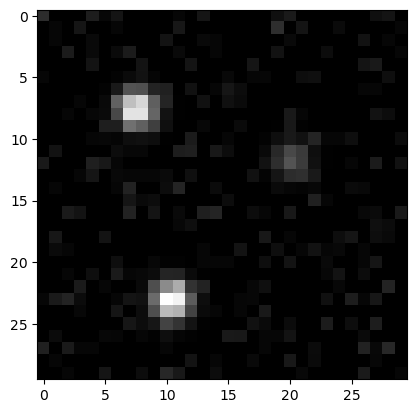

In [14]:
plt.imshow(noisy_array_test[0], cmap = 'gray')

Сorresponding to it clean image is following

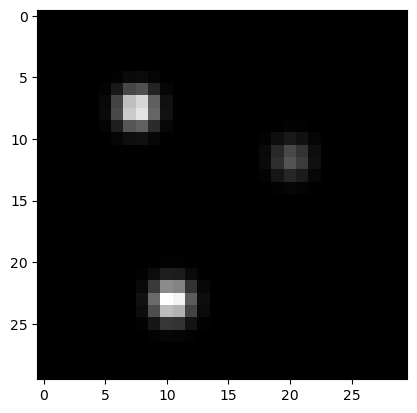

In [17]:
plt.imshow(clean_array_test[0], cmap = 'gray')

Now let's predict what the first test image after going through the autoencoder will look like

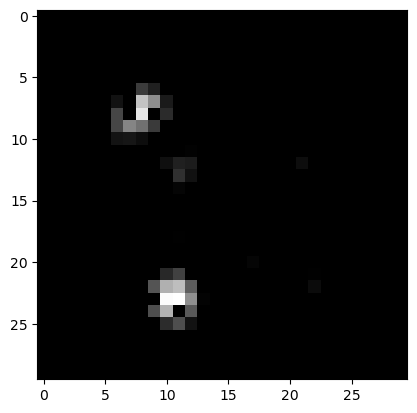

In [18]:
ae_out = autoencoder.predict([noisy_array_test[0].reshape(-1, 30, 30, 1)])[0]
plt.imshow(ae_out, cmap = 'gray')

Result is pretty good. We see the two main showers and the cue of the third shower

Let's denoise all images in the judge dataset

In [19]:
ae_out_judge = autoencoder.predict([noisy_array_judge])
ae_out_judge[0].shape

(30, 30, 1)

To change the dimention from 3 to 2 we can use function Squeeze

In [20]:
np.squeeze(ae_out_judge[0]).shape

(30, 30)

Then the first denoised image in the judge dataset looks like

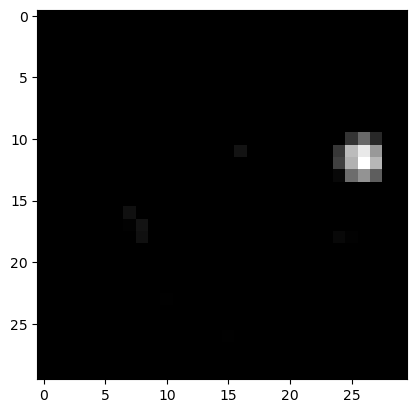

In [21]:
plt.imshow(np.squeeze(ae_out_judge[7]), cmap = 'gray')

Let's save all denoised images to the one directory. We going to use these clean images for the model that predicts the number of showers

In [22]:
import cv2
from PIL import Image as im
directory = r'C:/Users/matsiuk/Documents/Python Scripts/DATA/Problem5/judge_images/Clean'
os.chdir(directory)

for i, el in enumerate(ae_out_judge):
    filename = 'event00' + str(i).zfill(4) + '.png'
    arr = np.squeeze(el)
    img = im.fromarray((arr* 255).astype('uint8'), mode='L').save(filename)

The clean and noisy images are in the one directory what is not good for our future steps. So let's put clean and noisy images to the 2 folders (manually). The files have to be renamed as well to get rid of the first part clean_ in the beginning of the names. Let's do this for train and test data programatically

In [32]:
# Rename all file names in the directory Clean of train data
import os
 
os.chdir('C:/Users/matsiuk/Documents/Python Scripts/DATA/Problem5/train_images/Clean')
print(os.getcwd())
 
for count, f in enumerate(os.listdir()):
    f_name, f_ext = os.path.splitext(f)
    new_name = f_name.replace(r'clean_', '')
    new_name = f'{new_name}{f_ext}'
    os.rename(f, new_name)

C:\Users\matsiuk\Documents\Python Scripts\DATA\Problem5\train_images\Clean


In [33]:
# Rename all file names in the directory Clean of test data
os.chdir('C:/Users/matsiuk/Documents/Python Scripts/DATA/Problem5/test_images/Clean')
print(os.getcwd())
 
for count, f in enumerate(os.listdir()):
    f_name, f_ext = os.path.splitext(f)
    new_name = f_name.replace(r'clean_', '')
    new_name = f'{new_name}{f_ext}'
    os.rename(f, new_name)

C:\Users\matsiuk\Documents\Python Scripts\DATA\Problem5\test_images\Clean


Let's build a data generator. We will not divide the train dataset to the train and validation datasets, we'll just use test data for validation purpose

In [23]:
datagen = ImageDataGenerator()

The function flow_from_dataframe loads the labels from a Pandas dataframe connected to our train_images.csv file. 

We have to specify paths to the directories which contains all the images, because our x_col doesn't contain absolute_paths pointing to each image files instead of just filenames.

Parameter x_col points to the name of the column which contains the filenames of the images, y_col — points to the name of the column which contains the label.

We have to set class_mode equals to “categorical”, because we have the data in the column as categorical values (str datatype).

Batch_size will be 32 for the training and validation datasets and 1 for the test dataset.

Shuffle is set to True for train and validation generators and False for test generator, because we need to yield the images in “order”, to predict the outputs and match them with their unique filenames.

In [24]:
path_train = 'C:/Users/matsiuk/Documents/Python Scripts/DATA/Problem5/train_images/Clean'
path_test = 'C:/Users/matsiuk/Documents/Python Scripts/DATA/Problem5/test_images/Clean'
path_judge = 'C:/Users/matsiuk/Documents/Python Scripts/DATA/Problem5/judge_images/Clean'

train_generator=datagen.flow_from_dataframe(
                dataframe=df_train,
                directory=path_train,
                x_col="filename",
                y_col='number of showers',
                batch_size=32,
                seed=42,
                #shuffle=True,
                class_mode="categorical",
                target_size=(30,30),
                color_mode='grayscale')

valid_generator=datagen.flow_from_dataframe(
                dataframe=df_test,
                directory=path_test,
                x_col="filename",
                y_col='number of showers',
                batch_size=32,
                seed=42,
                #shuffle=True,
                class_mode="categorical",
                target_size=(30,30),
                color_mode='grayscale')

test_datagen=ImageDataGenerator()

test_generator=test_datagen.flow_from_dataframe(
                dataframe=df_judge,
                directory=path_judge,
                x_col="filename",
                y_col='number of showers',
                batch_size=1,
                seed=42,
                shuffle=False,
                class_mode=None,
                target_size=(30,30),
                color_mode='grayscale')

Found 10000 validated image filenames belonging to 6 classes.
Found 2000 validated image filenames belonging to 6 classes.
Found 2000 validated image filenames.


Now let's build the model that finds the number of showers on the image

In [25]:
class_count = len(train_generator.class_indices)

model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
          input_shape=(30,30,1)))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(class_count, activation='softmax'))
model.compile(optimizers.rmsprop(lr=0.0001, decay=1e-6), loss="categorical_crossentropy", metrics=["accuracy"])

Let's fit the model.

In [26]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

history = model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=10)

Epoch 1/10
312/312 [==============================] - 14s 46ms/step - loss: 1.7413 - accuracy: 0.3755 - val_loss: 1.3295 - val_accuracy: 0.4466
Epoch 2/10
312/312 [==============================] - 15s 47ms/step - loss: 1.1979 - accuracy: 0.4948 - val_loss: 0.9868 - val_accuracy: 0.5711
Epoch 3/10
312/312 [==============================] - 14s 46ms/step - loss: 0.9113 - accuracy: 0.5875 - val_loss: 0.7958 - val_accuracy: 0.6479
Epoch 4/10
312/312 [==============================] - 14s 46ms/step - loss: 0.8033 - accuracy: 0.6366 - val_loss: 0.8197 - val_accuracy: 0.6824
Epoch 5/10
312/312 [==============================] - 15s 47ms/step - loss: 0.7355 - accuracy: 0.6578 - val_loss: 0.6274 - val_accuracy: 0.7378
Epoch 6/10
312/312 [==============================] - 15s 47ms/step - loss: 0.6760 - accuracy: 0.6992 - val_loss: 0.5966 - val_accuracy: 0.7368
Epoch 7/10
312/312 [==============================] - 15s 47ms/step - loss: 0.6278 - accuracy: 0.7195 - val_loss: 0.6426 - val_accuracy:

To see the dynamics of accuracy we can build the plot

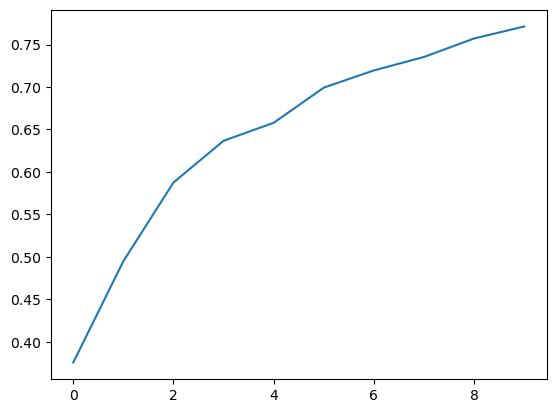

In [27]:
plt.plot(history.history['accuracy'])
plt.show()

Evaluate the model

In [28]:
model.evaluate_generator(generator=valid_generator, steps=STEP_SIZE_TEST)

[0.3788227438926697, 0.8043902516365051]

Let's predict the output for the judge dataset. We need to reset the test_generator before whenever you call the predict_generator. This is important, if we don't want to get outputs in a weird order.

In [29]:
test_generator.reset()
pred = model.predict_generator(test_generator, steps=STEP_SIZE_TEST, verbose=1)

2000/2000 [==============================] - 3s 1ms/step


Now we have to map the predicted labels with their unique ids such as filenames to find out what we predicted for which image.

In [30]:
predicted_class_indices = np.argmax(pred,axis=1)
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

We got the results of the first step, we found the predicted number of showers.

In [31]:
filenames = test_generator.filenames
results_1_step = pd.DataFrame({"Filename":filenames,
                               "Predictions":predictions})
results_1_step.head(10)

Filename Predictions
0  event000000.png           4
1  event000001.png           1
2  event000002.png           5
3  event000003.png           0
4  event000004.png           0
5  event000005.png           5
6  event000006.png           5
7  event000007.png           3
8  event000008.png           5
9  event000009.png           5

It doesn't look like the predicted values are accurate. Let's try to predict the number of showers without denoising. Let's build another Image Data Generator, train the model on the base of noisy data and predict the number of showers.

In [32]:
datagen_WD = ImageDataGenerator()

In [33]:
path_train = 'C:/Users/matsiuk/Documents/Python Scripts/DATA/Problem5/train_images/Noisy events'
path_test = 'C:/Users/matsiuk/Documents/Python Scripts/DATA/Problem5/test_images/Noisy events'
path_judge = 'C:/Users/matsiuk/Documents/Python Scripts/DATA/Problem5/judge_images/Noisy events'

train_generator_WD=datagen_WD.flow_from_dataframe(
                dataframe=df_train,
                directory=path_train,
                x_col="filename",
                y_col='number of showers',
                batch_size=32,
                seed=42,
                #shuffle=True,
                class_mode="categorical",
                target_size=(30,30),
                color_mode='grayscale')

valid_generator_WD=datagen_WD.flow_from_dataframe(
                dataframe=df_test,
                directory=path_test,
                x_col="filename",
                y_col='number of showers',
                batch_size=32,
                seed=42,
                #shuffle=True,
                class_mode="categorical",
                target_size=(30,30),
                color_mode='grayscale')

test_datagen_WD = ImageDataGenerator()

test_generator_WD=test_datagen_WD.flow_from_dataframe(
                dataframe=df_judge,
                directory=path_judge,
                x_col="filename",
                y_col='number of showers',
                batch_size=1,
                seed=42,
                shuffle=False,
                class_mode=None,
                target_size=(30,30),
                color_mode='grayscale')

Found 10000 validated image filenames belonging to 6 classes.
Found 2000 validated image filenames belonging to 6 classes.
Found 2000 validated image filenames.


In [34]:
STEP_SIZE_TRAIN=train_generator_WD.n//train_generator_WD.batch_size
STEP_SIZE_VALID=valid_generator_WD.n//valid_generator_WD.batch_size
STEP_SIZE_TEST=test_generator_WD.n//test_generator_WD.batch_size

history = model.fit_generator(generator=train_generator_WD,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator_WD,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=10)

Epoch 1/10
312/312 [==============================] - 23s 73ms/step - loss: 1.8715 - accuracy: 0.4601 - val_loss: 0.7139 - val_accuracy: 0.6562
Epoch 2/10
312/312 [==============================] - 14s 46ms/step - loss: 0.8129 - accuracy: 0.6445 - val_loss: 0.9761 - val_accuracy: 0.6565
Epoch 3/10
312/312 [==============================] - 15s 47ms/step - loss: 0.7504 - accuracy: 0.6694 - val_loss: 0.5894 - val_accuracy: 0.7480
Epoch 4/10
312/312 [==============================] - 14s 46ms/step - loss: 0.7178 - accuracy: 0.6845 - val_loss: 0.7161 - val_accuracy: 0.7317
Epoch 5/10
312/312 [==============================] - 15s 47ms/step - loss: 0.6678 - accuracy: 0.7088 - val_loss: 0.4934 - val_accuracy: 0.7470
Epoch 6/10
312/312 [==============================] - 14s 46ms/step - loss: 0.6319 - accuracy: 0.7220 - val_loss: 0.9570 - val_accuracy: 0.6850
Epoch 7/10
312/312 [==============================] - 14s 46ms/step - loss: 0.6091 - accuracy: 0.7323 - val_loss: 0.6041 - val_accuracy:

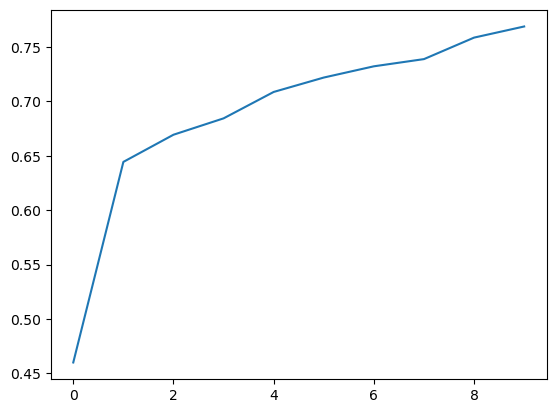

In [35]:
plt.plot(history.history['accuracy'])
plt.show()

In [39]:
model.evaluate_generator(generator=valid_generator_WD, steps=STEP_SIZE_TEST)

[0.4496784508228302, 0.7878243923187256]

In [36]:
test_generator_WD.reset()
pred = model.predict_generator(test_generator_WD, steps=STEP_SIZE_TEST, verbose=1)

2000/2000 [==============================] - 3s 1ms/step


In [37]:
predicted_class_indices_WD = np.argmax(pred,axis=1)
labels = (train_generator_WD.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions_WD = [labels[k] for k in predicted_class_indices_WD]

Let's output the results. To see the difference it makes sence to compare the values gotten with and without denoining 

In [38]:
results_1_step['Predictions without denoising'] = predictions_WD
results_1_step.head(10)

Filename Predictions Predictions without denoising
0  event000000.png           4                             1
1  event000001.png           1                             0
2  event000002.png           5                             4
3  event000003.png           0                             0
4  event000004.png           0                             0
5  event000005.png           5                             4
6  event000006.png           5                             4
7  event000007.png           3                             1
8  event000008.png           5                             5
9  event000009.png           5                             1

Some results are identical, but some differ a lot. For instance, for event000007 the model with denoising component predicted 4 showers and the model without denoining component predicted just 1 shower. Let's take a look on the picture of event000007

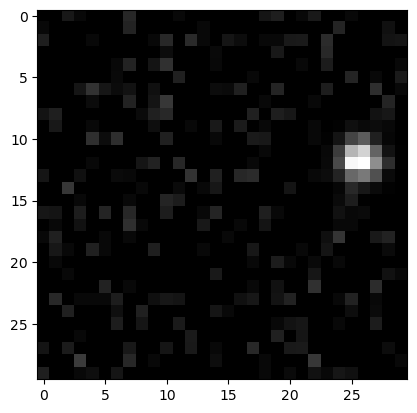

In [40]:
plt.imshow(noisy_array_judge[7], cmap = 'gray')

We clearly see the one shower and lots of noise. But how the cleared image looks like?

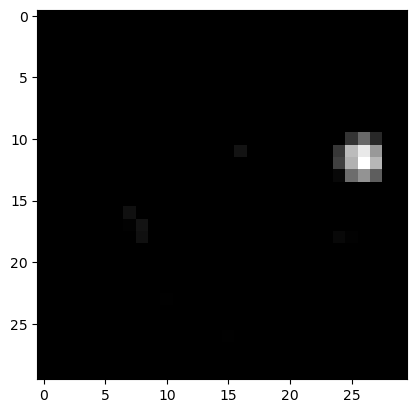

In [41]:
plt.imshow(ae_out_judge[7], cmap = 'gray')

The noise is pretty much gone by the naked eye, but apparently the model considers that the noise oddments are showers too. 

So, probably we should move forward with the approach that doesn't include image denoising

The next step is to find amplitude, coordinate X and Y for the each shower. We have 6 cases: no showers, 1 shower, 2 showers, 3 showers, 4 showers, 5 showers.
For the next step we will use the model from the first task that predict amplitude, coordinate X and Y for the one shower. And instead of pictures we will take a CSV-file as an input.

Let's load the model from the first task

In [42]:
os.chdir('C:/Users/matsiuk/Documents/Python Scripts')
model1 = tf.keras.models.load_model("find_amp_X_Y_model.keras")

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


The function that takes the first 900 columns is also the same as in the first task

In [43]:
#function that retrieves the input variable columns from the CSV and returns a pandas dataframe containing the columns
def retrieve_X_df(df, verbose = True):
  """
  :param df: Required, the dataframe containing the input and output variables. The first 900 values for each observation are assumed the input variables.
  :param verbose: Optional, default==True, prints the shape of the dataframe after retrieving the input columns.

  :return: dataframe containing the input data. 
  """
  df = df.iloc[:,0:900]
  if verbose:
    print("df shape: ", df.shape)
  return df

Let's read the judge dataset and use the model to predict the amplitude, coordinate X and Y for the one shower on the base of it 

In [44]:
#Read judge csv 
df_judge = pd.read_csv(os.path.join(source,"judge.csv"), na_values=['NA', '?'], header=None)

#Get inputs
df_judge_X = retrieve_X_df(df_judge)

#Predict the outputs 
preds_judge = model1.predict(df_judge_X)

#Put the predictions into the dataframe
output_judge = pd.DataFrame({'number_of_showers':predictions_WD,'amplitude':preds_judge[:,0].flatten(),
                             'X':preds_judge[:,1].flatten(),'Y':preds_judge[:,2].flatten()})
output_judge.tail(9)

df shape:  (2000, 900)


number_of_showers  amplitude           X           Y
1991                 5   3.601606   -8.801623   -8.002160
1992                 1   3.601606   -8.801623   -8.002160
1993                 5   3.740137  373.119263  299.424377
1994                 3   3.859244  164.441376   78.138046
1995                 2   2.815051  -27.558758  116.914963
1996                 3   3.601606   -8.801623   -8.002160
1997                 2   3.636208  -16.745020   -4.268338
1998                 4   3.706583  -79.287590 -141.852219
1999                 5   3.253794  304.342041  304.258026

It would be great to see our whole dataframe. Pandas has an options system that lets you customize some aspects of its behavior, display-related options being those the user is most likely to adjust. For instance, we can change the number of columns to be displayed using set_option function

In [45]:
pd.set_option('max_columns', None)
df_judge.tail(10)

0       1       2       3       4       5       6     7       8    \
1990  0.0000  0.0000  0.0000  0.0000  0.0000  0.0500  0.0617  0.00  0.0000   
1991  0.0000  0.0000  0.3663  0.0000  0.3037  0.0000  0.0000  0.00  0.0000   
1992  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.1296  0.00  0.2133   
1993  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.05  0.0000   
1994  0.0000  0.0000  0.0000  0.0000  0.0819  0.0000  0.0000  0.00  0.1131   
1995  0.0000  0.1621  0.0000  0.0000  0.0500  0.0536  0.0909  0.00  0.0000   
1996  0.0000  0.0000  0.0000  0.0513  0.0000  0.0000  0.0000  0.00  0.0000   
1997  0.0000  0.0000  0.0705  0.0601  0.0000  0.0970  0.0000  0.00  0.0000   
1998  0.0069  0.0191  0.0810  0.0092  0.0016  0.0001  0.0000  0.00  0.0000   
1999  0.0000  0.0000  0.2127  0.0000  0.0954  0.0000  0.1402  0.00  0.0000   

         9       10      11      12      13      14      15      16      17   \
1990  0.0000  0.2022  0.0000  0.0000  0.2898  0.0000  0.0000  0.0500  0.0000   
1991  0.0000  0.0000  0.0000  0.0000  0.0000  0.0500  0.1080  0.1879  0.0000   
1992  0.1015  0.1046  0.0000  0.0000  0.2452  0.0000  0.0500  0.0000  0.0000   
1993  0.0000  0.1009  0.0000  0.0542  0.0000  0.0000  0.0000  0.0000  0.0000   
1994  0.0915  0.0000  0.0000  0.0000  0.0000  0.0000  0.0500  0.0000  0.0500   
1995  0.0000  0.1872  0.2227  0.0840  0.0000  0.0000  0.0000  0.0000  0.0000   
1996  0.0000  0.0000  0.0500  0.0000  0.0000  0.0000  0.0860  0.1361  0.0500   
1997  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
1998  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0006  0.0043  0.0122   
1999  0.0500  0.0000  0.0000  0.0000  0.1390  0.1254  0.0000  0.0000  0.0000   

         18      19      20      21      22      23      24      25      26   \
1990  0.0000  0.0000  0.0573  0.1052  0.0000  0.0000  0.0000  0.0000  0.0000   
1991  0.0000  0.2047  0.0000  0.0000  0.0001  0.0003  0.0502  0.0000  0.2221   
1992  0.0000  0.3200  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
1993  0.0000  0.0000  0.0000  0.0000  0.0000  0.0500  0.0000  0.0000  0.3286   
1994  0.0000  0.0500  0.0000  0.0500  0.1720  0.0504  0.0074  0.0591  0.1867   
1995  0.0500  0.0500  0.0000  0.0000  0.0000  0.0000  0.0000  0.0606  0.0000   
1996  0.0000  0.0000  0.0000  0.1711  0.0000  0.0000  0.2639  0.0000  0.0000   
1997  0.0000  0.0500  0.2616  0.0000  0.0000  0.1954  0.0000  0.1764  0.1666   
1998  0.0138  0.0063  0.0011  0.0001  0.0000  0.0000  0.0608  0.0500  0.0000   
1999  0.0000  0.0000  0.0000  0.2410  0.0000  0.0500  0.0000  0.0000  0.0000   

         27      28      29      30      31      32      33      34      35   \
1990  0.0000  0.0000  0.0000  0.1894  0.1916  0.0000  0.0000  0.0000  0.0500   
1991  0.0000  0.2787  0.0000  0.0000  0.0575  0.0000  0.0000  0.0000  0.0000   
1992  0.0000  0.0000  0.0000  0.0000  0.0869  0.0000  0.0000  0.0000  0.0888   
1993  0.0000  0.0000  0.0000  0.0000  0.1434  0.0000  0.0000  0.0000  0.0000   
1994  0.4483  0.1174  0.0233  0.0000  0.0000  0.0000  0.2256  0.0000  0.0500   
1995  0.0000  0.0000  0.0579  0.0000  0.1735  0.0000  0.0000  0.0929  0.0000   
1996  0.0000  0.0000  0.0000  0.0000  0.0000  0.0963  0.1777  0.0500  0.1240   
1997  0.0000  0.0000  0.0000  0.2588  0.0000  0.0000  0.3227  0.0000  0.0000   
1998  0.0963  0.0000  0.0000  0.0966  0.2671  0.2940  0.1288  0.0224  0.0015   
1999  0.0000  0.2215  0.0000  0.0000  0.0000  0.0000  0.0000  0.1303  0.0000   

         36      37      38      39      40      41      42      43      44   \
1990  0.0000  0.0000  0.0000  0.0000  0.0000  0.0500  0.0000  0.0000  0.0000   
1991  0.2020  0.0000  0.0000  0.0000  0.0883  0.0000  0.0000  0.0000  0.0000   
1992  0.0918  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
1993  0.0000  0.0000  0.0606  0.1757  0.0000  0.0000  0.0000  0.0000  0.0000   
1994  0.0000  0.0002  0.0509  0.2500  0.0016  0.0005  0.0001  0.0000  0.0000   
1995  0.0500  0.0000  0.105

Next we add the values we got on the previous step to the new dataframe

In [46]:
df_judge['number_of_showers'] = predictions_WD
df_judge['amplitude'] = preds_judge[:,0].flatten()
df_judge['X'] = preds_judge[:,1].flatten()
df_judge['Y'] = preds_judge[:,2].flatten()
df_judge.tail(12)

0       1       2       3       4       5       6     7       8  \
1988  0.0500  0.0000  0.0725  0.1439  0.0000  0.0000  0.0000  0.05  0.0000   
1989  0.0000  0.2461  0.0000  0.0000  0.0000  0.0000  0.0500  0.05  0.0000   
1990  0.0000  0.0000  0.0000  0.0000  0.0000  0.0500  0.0617  0.00  0.0000   
1991  0.0000  0.0000  0.3663  0.0000  0.3037  0.0000  0.0000  0.00  0.0000   
1992  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.1296  0.00  0.2133   
1993  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.05  0.0000   
1994  0.0000  0.0000  0.0000  0.0000  0.0819  0.0000  0.0000  0.00  0.1131   
1995  0.0000  0.1621  0.0000  0.0000  0.0500  0.0536  0.0909  0.00  0.0000   
1996  0.0000  0.0000  0.0000  0.0513  0.0000  0.0000  0.0000  0.00  0.0000   
1997  0.0000  0.0000  0.0705  0.0601  0.0000  0.0970  0.0000  0.00  0.0000   
1998  0.0069  0.0191  0.0810  0.0092  0.0016  0.0001  0.0000  0.00  0.0000   
1999  0.0000  0.0000  0.2127  0.0000  0.0954  0.0000  0.1402  0.00  0.0000   

           9      10      11      12      13      14      15      16      17  \
1988  0.0000  0.0000  0.0000  0.3123  0.0500  0.0000  0.0000  0.1588  0.0000   
1989  0.0000  0.0000  0.0000  0.0500  0.1348  0.0000  0.2666  0.0500  0.0671   
1990  0.0000  0.2022  0.0000  0.0000  0.2898  0.0000  0.0000  0.0500  0.0000   
1991  0.0000  0.0000  0.0000  0.0000  0.0000  0.0500  0.1080  0.1879  0.0000   
1992  0.1015  0.1046  0.0000  0.0000  0.2452  0.0000  0.0500  0.0000  0.0000   
1993  0.0000  0.1009  0.0000  0.0542  0.0000  0.0000  0.0000  0.0000  0.0000   
1994  0.0915  0.0000  0.0000  0.0000  0.0000  0.0000  0.0500  0.0000  0.0500   
1995  0.0000  0.1872  0.2227  0.0840  0.0000  0.0000  0.0000  0.0000  0.0000   
1996  0.0000  0.0000  0.0500  0.0000  0.0000  0.0000  0.0860  0.1361  0.0500   
1997  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
1998  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0006  0.0043  0.0122   
1999  0.0500  0.0000  0.0000  0.0000  0.1390  0.1254  0.0000  0.0000  0.0000   

          18      19      20      21      22      23      24      25      26  \
1988  0.0000  0.0000  0.0000  0.1763  0.0000  0.0000  0.0000  0.0000  0.0000   
1989  0.0000  0.0000  0.1845  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
1990  0.0000  0.0000  0.0573  0.1052  0.0000  0.0000  0.0000  0.0000  0.0000   
1991  0.0000  0.2047  0.0000  0.0000  0.0001  0.0003  0.0502  0.0000  0.2221   
1992  0.0000  0.3200  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
1993  0.0000  0.0000  0.0000  0.0000  0.0000  0.0500  0.0000  0.0000  0.3286   
1994  0.0000  0.0500  0.0000  0.0500  0.1720  0.0504  0.0074  0.0591  0.1867   
1995  0.0500  0.0500  0.0000  0.0000  0.0000  0.0000  0.0000  0.0606  0.0000   
1996  0.0000  0.0000  0.0000  0.1711  0.0000  0.0000  0.2639  0.0000  0.0000   
1997  0.0000  0.0500  0.2616  0.0000  0.0000  0.1954  0.0000  0.1764  0.1666   
1998  0.0138  0.0063  0.0011  0.0001  0.0000  0.0000  0.0608  0.0500  0.0000   
1999  0.0000  0.0000  0.0000  0.2410  0.0000  0.0500  0.0000  0.0000  0.0000   

          27      28      29      30      31      32      33      34      35  \
1988  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.1662  0.0500  0.0000   
1989  0.3023  0.0000  0.0000  0.0500  0.0000  0.0000  0.0000  0.0000  0.0677   
1990  0.0000  0.0000  0.0000  0.1894  0.1916  0.0000  0.0000  0.0000  0.0500   
1991  0.0000  0.2787  0.0000  0.0000  0.0575  0.0000  0.0000  0.0000  0.0000   
1992  0.0000  0.0000  0.0000  0.0000  0.0869  0.0000  0.0000  0.0000  0.0888   
1993  0.0000  0.0000  0.0000  0.0000  0.1434  0.0000  0.0000  0.0000  0.0000   
1994  0.4483  0.1174  0.0233  0.0000  0.0000  0.0000  0.2256  0.0000  0.0500   
1995  0.0000  0.0000  0.0579  0.0000  0.1735  0.0000  0.0000  0.0929  0.0000   
1996  0.0000  0.0000  0.0000  0.0000  0.0000  0.0963  0.1777  0.0500  0.1240   
1997  0.0000  0.0000  0.0000  0.2588  0.0000  0.0000  0.3227  0.0000  0.0000   
1998  0.0963  0.0000  0.0000  0.09

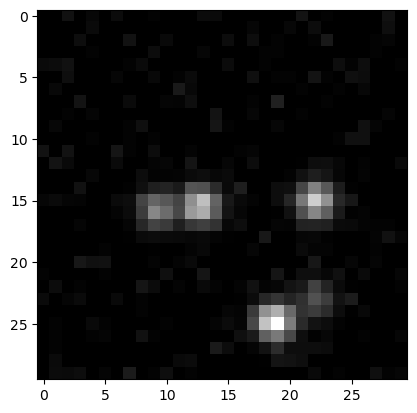

In [47]:
example_test = np.array(df_judge.iloc[-1,0:900])
example_test = example_test.astype('float64')
plt.imshow(example_test.reshape((30,30)), cmap = 'gray')

Next we build the function which takes a row as a parameter, assumes the amplitude is equal to 10 units, finds the location of the shower, masks this shower by changing the values of the pixels that consist the shower to zeros, and return a series without the shower

In [48]:
def find_and_mask_shower(row):
    rows = 30
    columns = 30
    
    arr = np.array(row[0:900])
    
    #reshape the array to get a 2-D array
    square = arr.reshape(30, 30)
    
    #find the coordinates of the brightest pixel
    coord_X, coord_Y = unravel_index(square.argmax(), square.shape)

    #assume the amplitude equals 10
    amp =  8
    
    #find the upper left corner of the area where the shower is located
    start_X = coord_X - amp/2
    start_Y = coord_Y - amp/2

    #find lower right corner of the area which consists the shower
    end_X = start_X + amp
    end_Y = start_Y + amp

    #then set the pixels between the start and end corners to zeros
    for r in range(rows):
        for c in range(columns):
            if (r >= start_X) and (r <= end_X) and (c >= start_Y) and (c <= end_Y):
                square[r,c] = 0 


    fl = square.flatten()
    #create Series of the 900 new values and return it
    s = pd.Series(fl, copy=False)
    
    return s

Let's check how the function works

Create a slice of the judge dataframe for experiments

In [49]:
df_judge1 = df_judge.iloc[-10::].copy()
df_judge1

0       1       2       3       4       5       6     7       8  \
1990  0.0000  0.0000  0.0000  0.0000  0.0000  0.0500  0.0617  0.00  0.0000   
1991  0.0000  0.0000  0.3663  0.0000  0.3037  0.0000  0.0000  0.00  0.0000   
1992  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.1296  0.00  0.2133   
1993  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.05  0.0000   
1994  0.0000  0.0000  0.0000  0.0000  0.0819  0.0000  0.0000  0.00  0.1131   
1995  0.0000  0.1621  0.0000  0.0000  0.0500  0.0536  0.0909  0.00  0.0000   
1996  0.0000  0.0000  0.0000  0.0513  0.0000  0.0000  0.0000  0.00  0.0000   
1997  0.0000  0.0000  0.0705  0.0601  0.0000  0.0970  0.0000  0.00  0.0000   
1998  0.0069  0.0191  0.0810  0.0092  0.0016  0.0001  0.0000  0.00  0.0000   
1999  0.0000  0.0000  0.2127  0.0000  0.0954  0.0000  0.1402  0.00  0.0000   

           9      10      11      12      13      14      15      16      17  \
1990  0.0000  0.2022  0.0000  0.0000  0.2898  0.0000  0.0000  0.0500  0.0000   
1991  0.0000  0.0000  0.0000  0.0000  0.0000  0.0500  0.1080  0.1879  0.0000   
1992  0.1015  0.1046  0.0000  0.0000  0.2452  0.0000  0.0500  0.0000  0.0000   
1993  0.0000  0.1009  0.0000  0.0542  0.0000  0.0000  0.0000  0.0000  0.0000   
1994  0.0915  0.0000  0.0000  0.0000  0.0000  0.0000  0.0500  0.0000  0.0500   
1995  0.0000  0.1872  0.2227  0.0840  0.0000  0.0000  0.0000  0.0000  0.0000   
1996  0.0000  0.0000  0.0500  0.0000  0.0000  0.0000  0.0860  0.1361  0.0500   
1997  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
1998  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0006  0.0043  0.0122   
1999  0.0500  0.0000  0.0000  0.0000  0.1390  0.1254  0.0000  0.0000  0.0000   

          18      19      20      21      22      23      24      25      26  \
1990  0.0000  0.0000  0.0573  0.1052  0.0000  0.0000  0.0000  0.0000  0.0000   
1991  0.0000  0.2047  0.0000  0.0000  0.0001  0.0003  0.0502  0.0000  0.2221   
1992  0.0000  0.3200  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
1993  0.0000  0.0000  0.0000  0.0000  0.0000  0.0500  0.0000  0.0000  0.3286   
1994  0.0000  0.0500  0.0000  0.0500  0.1720  0.0504  0.0074  0.0591  0.1867   
1995  0.0500  0.0500  0.0000  0.0000  0.0000  0.0000  0.0000  0.0606  0.0000   
1996  0.0000  0.0000  0.0000  0.1711  0.0000  0.0000  0.2639  0.0000  0.0000   
1997  0.0000  0.0500  0.2616  0.0000  0.0000  0.1954  0.0000  0.1764  0.1666   
1998  0.0138  0.0063  0.0011  0.0001  0.0000  0.0000  0.0608  0.0500  0.0000   
1999  0.0000  0.0000  0.0000  0.2410  0.0000  0.0500  0.0000  0.0000  0.0000   

          27      28      29      30      31      32      33      34      35  \
1990  0.0000  0.0000  0.0000  0.1894  0.1916  0.0000  0.0000  0.0000  0.0500   
1991  0.0000  0.2787  0.0000  0.0000  0.0575  0.0000  0.0000  0.0000  0.0000   
1992  0.0000  0.0000  0.0000  0.0000  0.0869  0.0000  0.0000  0.0000  0.0888   
1993  0.0000  0.0000  0.0000  0.0000  0.1434  0.0000  0.0000  0.0000  0.0000   
1994  0.4483  0.1174  0.0233  0.0000  0.0000  0.0000  0.2256  0.0000  0.0500   
1995  0.0000  0.0000  0.0579  0.0000  0.1735  0.0000  0.0000  0.0929  0.0000   
1996  0.0000  0.0000  0.0000  0.0000  0.0000  0.0963  0.1777  0.0500  0.1240   
1997  0.0000  0.0000  0.0000  0.2588  0.0000  0.0000  0.3227  0.0000  0.0000   
1998  0.0963  0.0000  0.0000  0.0966  0.2671  0.2940  0.1288  0.0224  0.0015   
1999  0.0000  0.2215  0.0000  0.0000  0.0000  0.0000  0.0000  0.1303  0.0000   

          36      37      38      39      40      41      42      43      44  \
1990  0.0000  0.0000  0.0000  0.0000  0.0000  0.0500  0.0000  0.0000  0.0000   
1991  0.2020  0.0000  0.0000  0.0000  0.0883  0.0000  0.0000  0.0000  0.0000   
1992  0.0918  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
1993  0.0000  0.0000  0.0606  0.1757  0.0000  0.0000  0.0000  0.0000  0.0000   
1994  0.0000  0.0002  0.0509  0.2500  0.0016  0.0005  0.0001  0.0000  0.0000   
1995  0.0500  0.0000  0.1059 

Let's take a look on the third from the bottom row which has 2 showers

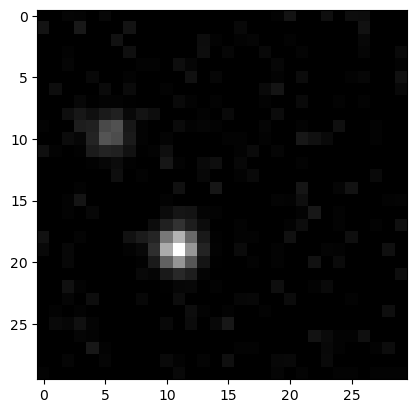

In [50]:
ex = np.array(df_judge1.iloc[-3,0:900])
ex = ex.astype('float64')
plt.imshow(ex.reshape((30,30)), cmap = 'gray')

Apply the masking function to the whole dataframe 

In [51]:
df_judge1.iloc[:,0:900] = df_judge1.apply(lambda x: find_and_mask_shower(x), axis = 1)
df_judge1

0       1       2       3       4       5       6     7       8  \
1990  0.0  0.0000  0.0000  0.0000  0.0000  0.0500  0.0617  0.00  0.0000   
1991  0.0  0.0000  0.3663  0.0000  0.3037  0.0000  0.0000  0.00  0.0000   
1992  0.0  0.0000  0.0000  0.0000  0.0000  0.0000  0.1296  0.00  0.2133   
1993  0.0  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.05  0.0000   
1994  0.0  0.0000  0.0000  0.0000  0.0819  0.0000  0.0000  0.00  0.1131   
1995  0.0  0.1621  0.0000  0.0000  0.0500  0.0536  0.0909  0.00  0.0000   
1996  0.0  0.0000  0.0000  0.0513  0.0000  0.0000  0.0000  0.00  0.0000   
1997  0.0  0.0000  0.0705  0.0601  0.0000  0.0970  0.0000  0.00  0.0000   
1998  0.0  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.00  0.0000   
1999  0.0  0.0000  0.2127  0.0000  0.0954  0.0000  0.1402  0.00  0.0000   

           9      10      11      12      13      14      15      16      17  \
1990  0.0000  0.2022  0.0000  0.0000  0.2898  0.0000  0.0000  0.0500  0.0000   
1991  0.0000  0.0000  0.0000  0.0000  0.0000  0.0500  0.1080  0.1879  0.0000   
1992  0.1015  0.1046  0.0000  0.0000  0.2452  0.0000  0.0500  0.0000  0.0000   
1993  0.0000  0.1009  0.0000  0.0542  0.0000  0.0000  0.0000  0.0000  0.0000   
1994  0.0915  0.0000  0.0000  0.0000  0.0000  0.0000  0.0500  0.0000  0.0500   
1995  0.0000  0.1872  0.2227  0.0840  0.0000  0.0000  0.0000  0.0000  0.0000   
1996  0.0000  0.0000  0.0500  0.0000  0.0000  0.0000  0.0860  0.1361  0.0500   
1997  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
1998  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0006  0.0043  0.0122   
1999  0.0500  0.0000  0.0000  0.0000  0.1390  0.1254  0.0000  0.0000  0.0000   

          18      19      20      21      22      23      24      25      26  \
1990  0.0000  0.0000  0.0573  0.1052  0.0000  0.0000  0.0000  0.0000  0.0000   
1991  0.0000  0.2047  0.0000  0.0000  0.0001  0.0003  0.0502  0.0000  0.2221   
1992  0.0000  0.3200  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
1993  0.0000  0.0000  0.0000  0.0000  0.0000  0.0500  0.0000  0.0000  0.3286   
1994  0.0000  0.0500  0.0000  0.0500  0.1720  0.0504  0.0074  0.0591  0.1867   
1995  0.0500  0.0500  0.0000  0.0000  0.0000  0.0000  0.0000  0.0606  0.0000   
1996  0.0000  0.0000  0.0000  0.1711  0.0000  0.0000  0.2639  0.0000  0.0000   
1997  0.0000  0.0500  0.2616  0.0000  0.0000  0.1954  0.0000  0.1764  0.1666   
1998  0.0138  0.0063  0.0011  0.0001  0.0000  0.0000  0.0608  0.0500  0.0000   
1999  0.0000  0.0000  0.0000  0.2410  0.0000  0.0500  0.0000  0.0000  0.0000   

          27      28      29      30      31      32      33      34      35  \
1990  0.0000  0.0000  0.0000  0.1894  0.1916  0.0000  0.0000  0.0000  0.0500   
1991  0.0000  0.2787  0.0000  0.0000  0.0575  0.0000  0.0000  0.0000  0.0000   
1992  0.0000  0.0000  0.0000  0.0000  0.0869  0.0000  0.0000  0.0000  0.0888   
1993  0.0000  0.0000  0.0000  0.0000  0.1434  0.0000  0.0000  0.0000  0.0000   
1994  0.4483  0.1174  0.0233  0.0000  0.0000  0.0000  0.2256  0.0000  0.0500   
1995  0.0000  0.0000  0.0579  0.0000  0.1735  0.0000  0.0000  0.0929  0.0000   
1996  0.0000  0.0000  0.0000  0.0000  0.0000  0.0963  0.1777  0.0500  0.1240   
1997  0.0000  0.0000  0.0000  0.2588  0.0000  0.0000  0.3227  0.0000  0.0000   
1998  0.0963  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
1999  0.0000  0.2215  0.0000  0.0000  0.0000  0.0000  0.0000  0.1303  0.0000   

          36      37      38      39      40      41      42      43      44  \
1990  0.0000  0.0000  0.0000  0.0000  0.0000  0.0500  0.0000  0.0000  0.0000   
1991  0.2020  0.0000  0.0000  0.0000  0.0883  0.0000  0.0000  0.0000  0.0000   
1992  0.0918  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
1993  0.0000  0.0000  0.0606  0.1757  0.0000  0.0000  0.0000  0.0000  0.0000   
1994  0.0000  0.0002  0.0509  0.2500  0.0016  0.0005  0.0001  0.0000  0.0000   
1995  0.0500  0.0000  0.1059  0.0000  0.0500  0.0000  0.000

And take a look on the third from the bottom row again

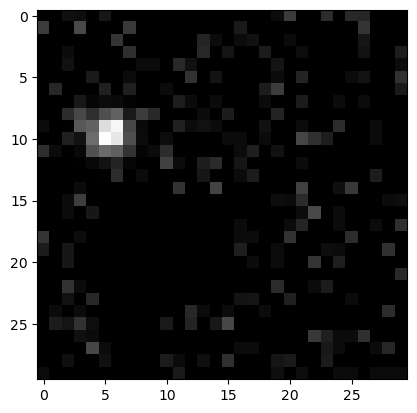

In [52]:
plt.imshow(np.array(df_judge1.iloc[-3:-2,0:900]).reshape((30,30)), cmap = 'gray')

We can see that the one of the two showers is gone. This is exactly what we needed 

So let's create a copy of the dataframe and apply the function that masks the shower

In [53]:
df_judge_1_shower_masked = df_judge.copy()
df_judge_1_shower_masked.iloc[:,0:900] = df_judge_1_shower_masked.apply(lambda x: find_and_mask_shower(x), axis = 1)
df_judge_1_shower_masked.tail(12)

0       1       2       3       4       5       6     7       8  \
1988  0.05  0.0000  0.0725  0.1439  0.0000  0.0000  0.0000  0.05  0.0000   
1989  0.00  0.2461  0.0000  0.0000  0.0000  0.0000  0.0500  0.05  0.0000   
1990  0.00  0.0000  0.0000  0.0000  0.0000  0.0500  0.0617  0.00  0.0000   
1991  0.00  0.0000  0.3663  0.0000  0.3037  0.0000  0.0000  0.00  0.0000   
1992  0.00  0.0000  0.0000  0.0000  0.0000  0.0000  0.1296  0.00  0.2133   
1993  0.00  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.05  0.0000   
1994  0.00  0.0000  0.0000  0.0000  0.0819  0.0000  0.0000  0.00  0.1131   
1995  0.00  0.1621  0.0000  0.0000  0.0500  0.0536  0.0909  0.00  0.0000   
1996  0.00  0.0000  0.0000  0.0513  0.0000  0.0000  0.0000  0.00  0.0000   
1997  0.00  0.0000  0.0705  0.0601  0.0000  0.0970  0.0000  0.00  0.0000   
1998  0.00  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.00  0.0000   
1999  0.00  0.0000  0.2127  0.0000  0.0954  0.0000  0.1402  0.00  0.0000   

           9      10      11      12      13      14      15      16      17  \
1988  0.0000  0.0000  0.0000  0.3123  0.0500  0.0000  0.0000  0.1588  0.0000   
1989  0.0000  0.0000  0.0000  0.0500  0.1348  0.0000  0.2666  0.0500  0.0671   
1990  0.0000  0.2022  0.0000  0.0000  0.2898  0.0000  0.0000  0.0500  0.0000   
1991  0.0000  0.0000  0.0000  0.0000  0.0000  0.0500  0.1080  0.1879  0.0000   
1992  0.1015  0.1046  0.0000  0.0000  0.2452  0.0000  0.0500  0.0000  0.0000   
1993  0.0000  0.1009  0.0000  0.0542  0.0000  0.0000  0.0000  0.0000  0.0000   
1994  0.0915  0.0000  0.0000  0.0000  0.0000  0.0000  0.0500  0.0000  0.0500   
1995  0.0000  0.1872  0.2227  0.0840  0.0000  0.0000  0.0000  0.0000  0.0000   
1996  0.0000  0.0000  0.0500  0.0000  0.0000  0.0000  0.0860  0.1361  0.0500   
1997  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
1998  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0006  0.0043  0.0122   
1999  0.0500  0.0000  0.0000  0.0000  0.1390  0.1254  0.0000  0.0000  0.0000   

          18      19      20      21      22      23      24      25      26  \
1988  0.0000  0.0000  0.0000  0.1763  0.0000  0.0000  0.0000  0.0000  0.0000   
1989  0.0000  0.0000  0.1845  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
1990  0.0000  0.0000  0.0573  0.1052  0.0000  0.0000  0.0000  0.0000  0.0000   
1991  0.0000  0.2047  0.0000  0.0000  0.0001  0.0003  0.0502  0.0000  0.2221   
1992  0.0000  0.3200  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
1993  0.0000  0.0000  0.0000  0.0000  0.0000  0.0500  0.0000  0.0000  0.3286   
1994  0.0000  0.0500  0.0000  0.0500  0.1720  0.0504  0.0074  0.0591  0.1867   
1995  0.0500  0.0500  0.0000  0.0000  0.0000  0.0000  0.0000  0.0606  0.0000   
1996  0.0000  0.0000  0.0000  0.1711  0.0000  0.0000  0.2639  0.0000  0.0000   
1997  0.0000  0.0500  0.2616  0.0000  0.0000  0.1954  0.0000  0.1764  0.1666   
1998  0.0138  0.0063  0.0011  0.0001  0.0000  0.0000  0.0608  0.0500  0.0000   
1999  0.0000  0.0000  0.0000  0.2410  0.0000  0.0500  0.0000  0.0000  0.0000   

          27      28      29      30      31      32      33      34      35  \
1988  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.1662  0.0500  0.0000   
1989  0.3023  0.0000  0.0000  0.0500  0.0000  0.0000  0.0000  0.0000  0.0677   
1990  0.0000  0.0000  0.0000  0.1894  0.1916  0.0000  0.0000  0.0000  0.0500   
1991  0.0000  0.2787  0.0000  0.0000  0.0575  0.0000  0.0000  0.0000  0.0000   
1992  0.0000  0.0000  0.0000  0.0000  0.0869  0.0000  0.0000  0.0000  0.0888   
1993  0.0000  0.0000  0.0000  0.0000  0.1434  0.0000  0.0000  0.0000  0.0000   
1994  0.4483  0.1174  0.0233  0.0000  0.0000  0.0000  0.2256  0.0000  0.0500   
1995  0.0000  0.0000  0.0579  0.0000  0.1735  0.0000  0.0000  0.0929  0.0000   
1996  0.0000  0.0000  0.0000  0.0000  0.0000  0.0963  0.1777  0.0500  0.1240   
1997  0.0000  0.0000  0.0000  0.2588  0.0000  0.0000  0.3227  0.0000  0.0000   
1998  0.0963  0.0000  0.0000  0.0000  0.0000  0.0000  0.00

Let's try to use our model again on the base of the new data to find the amplitude, coordinate X and Y of the second shower

In [54]:
df_X = df_judge_1_shower_masked.iloc[:,0:900]

#Predict the new outputs 
preds_judge_minus_1_shower = model1.predict(df_X)

#Add the new predictions to the dataframe
df_judge_1_shower_masked['amplitude2'] = preds_judge_minus_1_shower[:,0].flatten()
df_judge_1_shower_masked['X2'] = preds_judge_minus_1_shower[:,1].flatten()
df_judge_1_shower_masked['Y2'] = preds_judge_minus_1_shower[:,2].flatten()
df_judge_1_shower_masked.tail(20)

0       1       2       3       4       5       6       7       8  \
1980  0.2245  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.1572  0.0000   
1981  0.0000  0.0000  0.0000  0.1866  0.0000  0.0000  0.1239  0.0500  0.0000   
1982  0.1613  0.2051  0.1052  0.0000  0.0000  0.0000  0.0500  0.0000  0.0000   
1983  0.0836  0.1697  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
1984  0.0000  0.0000  0.0000  0.0000  0.2375  0.0500  0.0000  0.2205  0.0518   
1985  0.0000  0.0000  0.0000  0.0000  0.0000  0.0500  0.0000  0.0000  0.3320   
1986  0.0000  0.0500  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
1987  0.0000  0.0000  0.0000  0.0861  0.2562  0.2268  0.0500  0.0500  0.0000   
1988  0.0500  0.0000  0.0725  0.1439  0.0000  0.0000  0.0000  0.0500  0.0000   
1989  0.0000  0.2461  0.0000  0.0000  0.0000  0.0000  0.0500  0.0500  0.0000   
1990  0.0000  0.0000  0.0000  0.0000  0.0000  0.0500  0.0617  0.0000  0.0000   
1991  0.0000  0.0000  0.3663  0.0000  0.3037  0.0000  0.0000  0.0000  0.0000   
1992  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.1296  0.0000  0.2133   
1993  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0500  0.0000   
1994  0.0000  0.0000  0.0000  0.0000  0.0819  0.0000  0.0000  0.0000  0.1131   
1995  0.0000  0.1621  0.0000  0.0000  0.0500  0.0536  0.0909  0.0000  0.0000   
1996  0.0000  0.0000  0.0000  0.0513  0.0000  0.0000  0.0000  0.0000  0.0000   
1997  0.0000  0.0000  0.0705  0.0601  0.0000  0.0970  0.0000  0.0000  0.0000   
1998  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
1999  0.0000  0.0000  0.2127  0.0000  0.0954  0.0000  0.1402  0.0000  0.0000   

           9      10      11      12      13      14      15      16      17  \
1980  0.0000  0.0000  0.0000  0.1160  0.0000  0.0000  0.0500  0.0000  0.0000   
1981  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.2466  0.1194   
1982  0.0000  0.0000  0.0000  0.0000  0.0000  0.1946  0.1641  0.0500  0.0000   
1983  0.0000  0.0000  0.0000  0.0000  0.0000  0.1528  0.0000  0.0000  0.0677   
1984  0.0000  0.0000  0.0000  0.0000  0.1899  0.0000  0.0000  0.0000  0.0000   
1985  0.1298  0.0000  0.0000  0.0000  0.0000  0.1245  0.0000  0.0000  0.0500   
1986  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.2058  0.0000  0.0000   
1987  0.0000  0.0000  0.0000  0.0000  0.0000  0.1063  0.0000  0.0000  0.0000   
1988  0.0000  0.0000  0.0000  0.3123  0.0500  0.0000  0.0000  0.1588  0.0000   
1989  0.0000  0.0000  0.0000  0.0500  0.1348  0.0000  0.2666  0.0500  0.0671   
1990  0.0000  0.2022  0.0000  0.0000  0.2898  0.0000  0.0000  0.0500  0.0000   
1991  0.0000  0.0000  0.0000  0.0000  0.0000  0.0500  0.1080  0.1879  0.0000   
1992  0.1015  0.1046  0.0000  0.0000  0.2452  0.0000  0.0500  0.0000  0.0000   
1993  0.0000  0.1009  0.0000  0.0542  0.0000  0.0000  0.0000  0.0000  0.0000   
1994  0.0915  0.0000  0.0000  0.0000  0.0000  0.0000  0.0500  0.0000  0.0500   
1995  0.0000  0.1872  0.2227  0.0840  0.0000  0.0000  0.0000  0.0000  0.0000   
1996  0.0000  0.0000  0.0500  0.0000  0.0000  0.0000  0.0860  0.1361  0.0500   
1997  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
1998  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0006  0.0043  0.0122   
1999  0.0500  0.0000  0.0000  0.0000  0.1390  0.1254  0.0000  0.0000  0.0000   

          18      19      20      21      22      23      24      25      26  \
1980  0.1035  0.2519  0.0513  0.0000  0.0000  0.0000  0.0500  0.0000  0.0000   
1981  0.0000  0.1000  0.0500  0.0000  0.1404  0.0000  0.0000  0.0000  0.0000   
1982  0.0000  0.0000  0.0500  0.0500  0.0000  0.0000  0.1817  0.0000  0.2598   
1983  0.0000  0.2291  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
1984  0.2169  0.0000  0.0000  0.0000  0.0000  0.2040  0.1668  0.0500  0.0000   
1985  0.0000  0.0500  0.0000  0.0000  0.0000  0.0500  0.0000  0.0000  0.1019   
1986  0.0000  0.0582  0.0000  0.0500  0.0000  0.0000  0.0000  0.2412  0.0000   
1987  0.0

Set the amplitude, coordinate X and Y values equal to -1 for the rows which have no showers

In [55]:
df_judge_1_shower_masked['amplitude'] = df_judge_1_shower_masked.apply(lambda x: -1 if x['number_of_showers']=='0' else x['amplitude'], axis = 1)
df_judge_1_shower_masked['X'] = df_judge_1_shower_masked.apply(lambda x: -1 if x['number_of_showers']=='0' else x['X'], axis = 1)
df_judge_1_shower_masked['Y'] = df_judge_1_shower_masked.apply(lambda x: -1 if x['number_of_showers']=='0' else x['Y'], axis = 1)
df_judge_1_shower_masked.tail(15)

0       1       2       3       4       5       6     7       8  \
1985  0.00  0.0000  0.0000  0.0000  0.0000  0.0500  0.0000  0.00  0.3320   
1986  0.00  0.0500  0.0000  0.0000  0.0000  0.0000  0.0000  0.00  0.0000   
1987  0.00  0.0000  0.0000  0.0861  0.2562  0.2268  0.0500  0.05  0.0000   
1988  0.05  0.0000  0.0725  0.1439  0.0000  0.0000  0.0000  0.05  0.0000   
1989  0.00  0.2461  0.0000  0.0000  0.0000  0.0000  0.0500  0.05  0.0000   
1990  0.00  0.0000  0.0000  0.0000  0.0000  0.0500  0.0617  0.00  0.0000   
1991  0.00  0.0000  0.3663  0.0000  0.3037  0.0000  0.0000  0.00  0.0000   
1992  0.00  0.0000  0.0000  0.0000  0.0000  0.0000  0.1296  0.00  0.2133   
1993  0.00  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.05  0.0000   
1994  0.00  0.0000  0.0000  0.0000  0.0819  0.0000  0.0000  0.00  0.1131   
1995  0.00  0.1621  0.0000  0.0000  0.0500  0.0536  0.0909  0.00  0.0000   
1996  0.00  0.0000  0.0000  0.0513  0.0000  0.0000  0.0000  0.00  0.0000   
1997  0.00  0.0000  0.0705  0.0601  0.0000  0.0970  0.0000  0.00  0.0000   
1998  0.00  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.00  0.0000   
1999  0.00  0.0000  0.2127  0.0000  0.0954  0.0000  0.1402  0.00  0.0000   

           9      10      11      12      13      14      15      16      17  \
1985  0.1298  0.0000  0.0000  0.0000  0.0000  0.1245  0.0000  0.0000  0.0500   
1986  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.2058  0.0000  0.0000   
1987  0.0000  0.0000  0.0000  0.0000  0.0000  0.1063  0.0000  0.0000  0.0000   
1988  0.0000  0.0000  0.0000  0.3123  0.0500  0.0000  0.0000  0.1588  0.0000   
1989  0.0000  0.0000  0.0000  0.0500  0.1348  0.0000  0.2666  0.0500  0.0671   
1990  0.0000  0.2022  0.0000  0.0000  0.2898  0.0000  0.0000  0.0500  0.0000   
1991  0.0000  0.0000  0.0000  0.0000  0.0000  0.0500  0.1080  0.1879  0.0000   
1992  0.1015  0.1046  0.0000  0.0000  0.2452  0.0000  0.0500  0.0000  0.0000   
1993  0.0000  0.1009  0.0000  0.0542  0.0000  0.0000  0.0000  0.0000  0.0000   
1994  0.0915  0.0000  0.0000  0.0000  0.0000  0.0000  0.0500  0.0000  0.0500   
1995  0.0000  0.1872  0.2227  0.0840  0.0000  0.0000  0.0000  0.0000  0.0000   
1996  0.0000  0.0000  0.0500  0.0000  0.0000  0.0000  0.0860  0.1361  0.0500   
1997  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
1998  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0006  0.0043  0.0122   
1999  0.0500  0.0000  0.0000  0.0000  0.1390  0.1254  0.0000  0.0000  0.0000   

          18      19      20      21      22      23      24      25      26  \
1985  0.0000  0.0500  0.0000  0.0000  0.0000  0.0500  0.0000  0.0000  0.1019   
1986  0.0000  0.0582  0.0000  0.0500  0.0000  0.0000  0.0000  0.2412  0.0000   
1987  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
1988  0.0000  0.0000  0.0000  0.1763  0.0000  0.0000  0.0000  0.0000  0.0000   
1989  0.0000  0.0000  0.1845  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
1990  0.0000  0.0000  0.0573  0.1052  0.0000  0.0000  0.0000  0.0000  0.0000   
1991  0.0000  0.2047  0.0000  0.0000  0.0001  0.0003  0.0502  0.0000  0.2221   
1992  0.0000  0.3200  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
1993  0.0000  0.0000  0.0000  0.0000  0.0000  0.0500  0.0000  0.0000  0.3286   
1994  0.0000  0.0500  0.0000  0.0500  0.1720  0.0504  0.0074  0.0591  0.1867   
1995  0.0500  0.0500  0.0000  0.0000  0.0000  0.0000  0.0000  0.0606  0.0000   
1996  0.0000  0.0000  0.0000  0.1711  0.0000  0.0000  0.2639  0.0000  0.0000   
1997  0.0000  0.0500  0.2616  0.0000  0.0000  0.1954  0.0000  0.1764  0.1666   
1998  0.0138  0.0063  0.0011  0.0001  0.0000  0.0000  0.0608  0.0500  0.0000   
1999  0.0000  0.0000  0.0000  0.2410  0.0000  0.0500  0.0000  0.0000  0.0000   

          27      28      29      30      31      32      33      34      35  \
1985  0.0000  0.0500  0.0000  0.0500  0.0000  0.2497  0.0000  0.0000  0.0932   
1986  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.1152  0.0000  

Set the amplitude2, coordinate X2 and Y2 values equal to -1 for the rows which have exactly one shower

In [56]:
df_judge_1_shower_masked['amplitude2'] = df_judge_1_shower_masked.apply(lambda x: -1 if (x['number_of_showers']=='1' or x['number_of_showers']=='0')  else x['amplitude2'], axis = 1)
df_judge_1_shower_masked['X2'] = df_judge_1_shower_masked.apply(lambda x: -1 if (x['number_of_showers']=='1' or x['number_of_showers']=='0') else x['X2'], axis = 1)
df_judge_1_shower_masked['Y2'] = df_judge_1_shower_masked.apply(lambda x: -1 if (x['number_of_showers']=='1'or x['number_of_showers']=='0') else x['Y2'], axis = 1)
df_judge_1_shower_masked.tail(15)

0       1       2       3       4       5       6     7       8  \
1985  0.00  0.0000  0.0000  0.0000  0.0000  0.0500  0.0000  0.00  0.3320   
1986  0.00  0.0500  0.0000  0.0000  0.0000  0.0000  0.0000  0.00  0.0000   
1987  0.00  0.0000  0.0000  0.0861  0.2562  0.2268  0.0500  0.05  0.0000   
1988  0.05  0.0000  0.0725  0.1439  0.0000  0.0000  0.0000  0.05  0.0000   
1989  0.00  0.2461  0.0000  0.0000  0.0000  0.0000  0.0500  0.05  0.0000   
1990  0.00  0.0000  0.0000  0.0000  0.0000  0.0500  0.0617  0.00  0.0000   
1991  0.00  0.0000  0.3663  0.0000  0.3037  0.0000  0.0000  0.00  0.0000   
1992  0.00  0.0000  0.0000  0.0000  0.0000  0.0000  0.1296  0.00  0.2133   
1993  0.00  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.05  0.0000   
1994  0.00  0.0000  0.0000  0.0000  0.0819  0.0000  0.0000  0.00  0.1131   
1995  0.00  0.1621  0.0000  0.0000  0.0500  0.0536  0.0909  0.00  0.0000   
1996  0.00  0.0000  0.0000  0.0513  0.0000  0.0000  0.0000  0.00  0.0000   
1997  0.00  0.0000  0.0705  0.0601  0.0000  0.0970  0.0000  0.00  0.0000   
1998  0.00  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.00  0.0000   
1999  0.00  0.0000  0.2127  0.0000  0.0954  0.0000  0.1402  0.00  0.0000   

           9      10      11      12      13      14      15      16      17  \
1985  0.1298  0.0000  0.0000  0.0000  0.0000  0.1245  0.0000  0.0000  0.0500   
1986  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.2058  0.0000  0.0000   
1987  0.0000  0.0000  0.0000  0.0000  0.0000  0.1063  0.0000  0.0000  0.0000   
1988  0.0000  0.0000  0.0000  0.3123  0.0500  0.0000  0.0000  0.1588  0.0000   
1989  0.0000  0.0000  0.0000  0.0500  0.1348  0.0000  0.2666  0.0500  0.0671   
1990  0.0000  0.2022  0.0000  0.0000  0.2898  0.0000  0.0000  0.0500  0.0000   
1991  0.0000  0.0000  0.0000  0.0000  0.0000  0.0500  0.1080  0.1879  0.0000   
1992  0.1015  0.1046  0.0000  0.0000  0.2452  0.0000  0.0500  0.0000  0.0000   
1993  0.0000  0.1009  0.0000  0.0542  0.0000  0.0000  0.0000  0.0000  0.0000   
1994  0.0915  0.0000  0.0000  0.0000  0.0000  0.0000  0.0500  0.0000  0.0500   
1995  0.0000  0.1872  0.2227  0.0840  0.0000  0.0000  0.0000  0.0000  0.0000   
1996  0.0000  0.0000  0.0500  0.0000  0.0000  0.0000  0.0860  0.1361  0.0500   
1997  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
1998  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0006  0.0043  0.0122   
1999  0.0500  0.0000  0.0000  0.0000  0.1390  0.1254  0.0000  0.0000  0.0000   

          18      19      20      21      22      23      24      25      26  \
1985  0.0000  0.0500  0.0000  0.0000  0.0000  0.0500  0.0000  0.0000  0.1019   
1986  0.0000  0.0582  0.0000  0.0500  0.0000  0.0000  0.0000  0.2412  0.0000   
1987  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
1988  0.0000  0.0000  0.0000  0.1763  0.0000  0.0000  0.0000  0.0000  0.0000   
1989  0.0000  0.0000  0.1845  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
1990  0.0000  0.0000  0.0573  0.1052  0.0000  0.0000  0.0000  0.0000  0.0000   
1991  0.0000  0.2047  0.0000  0.0000  0.0001  0.0003  0.0502  0.0000  0.2221   
1992  0.0000  0.3200  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
1993  0.0000  0.0000  0.0000  0.0000  0.0000  0.0500  0.0000  0.0000  0.3286   
1994  0.0000  0.0500  0.0000  0.0500  0.1720  0.0504  0.0074  0.0591  0.1867   
1995  0.0500  0.0500  0.0000  0.0000  0.0000  0.0000  0.0000  0.0606  0.0000   
1996  0.0000  0.0000  0.0000  0.1711  0.0000  0.0000  0.2639  0.0000  0.0000   
1997  0.0000  0.0500  0.2616  0.0000  0.0000  0.1954  0.0000  0.1764  0.1666   
1998  0.0138  0.0063  0.0011  0.0001  0.0000  0.0000  0.0608  0.0500  0.0000   
1999  0.0000  0.0000  0.0000  0.2410  0.0000  0.0500  0.0000  0.0000  0.0000   

          27      28      29      30      31      32      33      34      35  \
1985  0.0000  0.0500  0.0000  0.0500  0.0000  0.2497  0.0000  0.0000  0.0932   
1986  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.1152  0.0000  

Next let's apply our function that masks a shower to those rows which have 3 showers

In [57]:
df_judge_2_showers_masked = df_judge_1_shower_masked.copy()
df_judge_2_showers_masked.iloc[:,0:900] = df_judge_2_showers_masked.apply(lambda x: find_and_mask_shower(x), axis = 1)
df_judge_2_showers_masked.tail(15)

0       1       2       3       4       5       6     7       8  \
1985  0.00  0.0000  0.0000  0.0000  0.0000  0.0500  0.0000  0.00  0.3320   
1986  0.00  0.0500  0.0000  0.0000  0.0000  0.0000  0.0000  0.00  0.0000   
1987  0.00  0.0000  0.0000  0.0861  0.2562  0.2268  0.0500  0.05  0.0000   
1988  0.05  0.0000  0.0725  0.1439  0.0000  0.0000  0.0000  0.05  0.0000   
1989  0.00  0.2461  0.0000  0.0000  0.0000  0.0000  0.0500  0.05  0.0000   
1990  0.00  0.0000  0.0000  0.0000  0.0000  0.0500  0.0617  0.00  0.0000   
1991  0.00  0.0000  0.3663  0.0000  0.3037  0.0000  0.0000  0.00  0.0000   
1992  0.00  0.0000  0.0000  0.0000  0.0000  0.0000  0.1296  0.00  0.2133   
1993  0.00  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.05  0.0000   
1994  0.00  0.0000  0.0000  0.0000  0.0819  0.0000  0.0000  0.00  0.1131   
1995  0.00  0.1621  0.0000  0.0000  0.0500  0.0536  0.0909  0.00  0.0000   
1996  0.00  0.0000  0.0000  0.0513  0.0000  0.0000  0.0000  0.00  0.0000   
1997  0.00  0.0000  0.0705  0.0601  0.0000  0.0970  0.0000  0.00  0.0000   
1998  0.00  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.00  0.0000   
1999  0.00  0.0000  0.2127  0.0000  0.0954  0.0000  0.1402  0.00  0.0000   

           9      10      11      12      13      14      15      16      17  \
1985  0.1298  0.0000  0.0000  0.0000  0.0000  0.1245  0.0000  0.0000  0.0500   
1986  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.2058  0.0000  0.0000   
1987  0.0000  0.0000  0.0000  0.0000  0.0000  0.1063  0.0000  0.0000  0.0000   
1988  0.0000  0.0000  0.0000  0.3123  0.0500  0.0000  0.0000  0.1588  0.0000   
1989  0.0000  0.0000  0.0000  0.0500  0.1348  0.0000  0.2666  0.0500  0.0671   
1990  0.0000  0.2022  0.0000  0.0000  0.2898  0.0000  0.0000  0.0500  0.0000   
1991  0.0000  0.0000  0.0000  0.0000  0.0000  0.0500  0.1080  0.1879  0.0000   
1992  0.1015  0.1046  0.0000  0.0000  0.2452  0.0000  0.0500  0.0000  0.0000   
1993  0.0000  0.1009  0.0000  0.0542  0.0000  0.0000  0.0000  0.0000  0.0000   
1994  0.0915  0.0000  0.0000  0.0000  0.0000  0.0000  0.0500  0.0000  0.0500   
1995  0.0000  0.1872  0.2227  0.0840  0.0000  0.0000  0.0000  0.0000  0.0000   
1996  0.0000  0.0000  0.0500  0.0000  0.0000  0.0000  0.0860  0.1361  0.0500   
1997  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
1998  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
1999  0.0500  0.0000  0.0000  0.0000  0.1390  0.1254  0.0000  0.0000  0.0000   

        18      19      20      21      22      23      24      25      26  \
1985  0.00  0.0500  0.0000  0.0000  0.0000  0.0500  0.0000  0.0000  0.1019   
1986  0.00  0.0582  0.0000  0.0500  0.0000  0.0000  0.0000  0.2412  0.0000   
1987  0.00  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
1988  0.00  0.0000  0.0000  0.1763  0.0000  0.0000  0.0000  0.0000  0.0000   
1989  0.00  0.0000  0.1845  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
1990  0.00  0.0000  0.0573  0.1052  0.0000  0.0000  0.0000  0.0000  0.0000   
1991  0.00  0.2047  0.0000  0.0000  0.0001  0.0003  0.0502  0.0000  0.2221   
1992  0.00  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
1993  0.00  0.0000  0.0000  0.0000  0.0000  0.0500  0.0000  0.0000  0.3286   
1994  0.00  0.0500  0.0000  0.0500  0.1720  0.0000  0.0000  0.0000  0.0000   
1995  0.05  0.0500  0.0000  0.0000  0.0000  0.0000  0.0000  0.0606  0.0000   
1996  0.00  0.0000  0.0000  0.1711  0.0000  0.0000  0.2639  0.0000  0.0000   
1997  0.00  0.0500  0.2616  0.0000  0.0000  0.1954  0.0000  0.1764  0.1666   
1998  0.00  0.0000  0.0000  0.0000  0.0000  0.0000  0.0608  0.0500  0.0000   
1999  0.00  0.0000  0.0000  0.2410  0.0000  0.0500  0.0000  0.0000  0.0000   

          27      28      29      30      31      32      33      34      35  \
1985  0.0000  0.0500  0.0000  0.0500  0.0000  0.2497  0.0000  0.0000  0.0932   
1986  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.1152  0.0000  0.0000   
1987  0.0000  0.0000  

Let's use our model again on the base of the new data to find the amplitude, coordinate X and Y of the third shower

In [59]:
df_X = df_judge_2_showers_masked.iloc[:,0:900]

#Predict the new outputs 
preds_judge_minus_2_showers = model1.predict(df_X)

#Add the new predictions to the dataframe
df_judge_2_showers_masked['amplitude3'] = preds_judge_minus_2_showers[:,0].flatten()
df_judge_2_showers_masked['X3'] = preds_judge_minus_2_showers[:,1].flatten()
df_judge_2_showers_masked['Y3'] = preds_judge_minus_2_showers[:,2].flatten()
df_judge_2_showers_masked.tail(15)

0       1       2       3       4       5       6     7       8  \
1985  0.00  0.0000  0.0000  0.0000  0.0000  0.0500  0.0000  0.00  0.3320   
1986  0.00  0.0500  0.0000  0.0000  0.0000  0.0000  0.0000  0.00  0.0000   
1987  0.00  0.0000  0.0000  0.0861  0.2562  0.2268  0.0500  0.05  0.0000   
1988  0.05  0.0000  0.0725  0.1439  0.0000  0.0000  0.0000  0.05  0.0000   
1989  0.00  0.2461  0.0000  0.0000  0.0000  0.0000  0.0500  0.05  0.0000   
1990  0.00  0.0000  0.0000  0.0000  0.0000  0.0500  0.0617  0.00  0.0000   
1991  0.00  0.0000  0.3663  0.0000  0.3037  0.0000  0.0000  0.00  0.0000   
1992  0.00  0.0000  0.0000  0.0000  0.0000  0.0000  0.1296  0.00  0.2133   
1993  0.00  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.05  0.0000   
1994  0.00  0.0000  0.0000  0.0000  0.0819  0.0000  0.0000  0.00  0.1131   
1995  0.00  0.1621  0.0000  0.0000  0.0500  0.0536  0.0909  0.00  0.0000   
1996  0.00  0.0000  0.0000  0.0513  0.0000  0.0000  0.0000  0.00  0.0000   
1997  0.00  0.0000  0.0705  0.0601  0.0000  0.0970  0.0000  0.00  0.0000   
1998  0.00  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.00  0.0000   
1999  0.00  0.0000  0.2127  0.0000  0.0954  0.0000  0.1402  0.00  0.0000   

           9      10      11      12      13      14      15      16      17  \
1985  0.1298  0.0000  0.0000  0.0000  0.0000  0.1245  0.0000  0.0000  0.0500   
1986  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.2058  0.0000  0.0000   
1987  0.0000  0.0000  0.0000  0.0000  0.0000  0.1063  0.0000  0.0000  0.0000   
1988  0.0000  0.0000  0.0000  0.3123  0.0500  0.0000  0.0000  0.1588  0.0000   
1989  0.0000  0.0000  0.0000  0.0500  0.1348  0.0000  0.2666  0.0500  0.0671   
1990  0.0000  0.2022  0.0000  0.0000  0.2898  0.0000  0.0000  0.0500  0.0000   
1991  0.0000  0.0000  0.0000  0.0000  0.0000  0.0500  0.1080  0.1879  0.0000   
1992  0.1015  0.1046  0.0000  0.0000  0.2452  0.0000  0.0500  0.0000  0.0000   
1993  0.0000  0.1009  0.0000  0.0542  0.0000  0.0000  0.0000  0.0000  0.0000   
1994  0.0915  0.0000  0.0000  0.0000  0.0000  0.0000  0.0500  0.0000  0.0500   
1995  0.0000  0.1872  0.2227  0.0840  0.0000  0.0000  0.0000  0.0000  0.0000   
1996  0.0000  0.0000  0.0500  0.0000  0.0000  0.0000  0.0860  0.1361  0.0500   
1997  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
1998  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
1999  0.0500  0.0000  0.0000  0.0000  0.1390  0.1254  0.0000  0.0000  0.0000   

        18      19      20      21      22      23      24      25      26  \
1985  0.00  0.0500  0.0000  0.0000  0.0000  0.0500  0.0000  0.0000  0.1019   
1986  0.00  0.0582  0.0000  0.0500  0.0000  0.0000  0.0000  0.2412  0.0000   
1987  0.00  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
1988  0.00  0.0000  0.0000  0.1763  0.0000  0.0000  0.0000  0.0000  0.0000   
1989  0.00  0.0000  0.1845  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
1990  0.00  0.0000  0.0573  0.1052  0.0000  0.0000  0.0000  0.0000  0.0000   
1991  0.00  0.2047  0.0000  0.0000  0.0001  0.0003  0.0502  0.0000  0.2221   
1992  0.00  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
1993  0.00  0.0000  0.0000  0.0000  0.0000  0.0500  0.0000  0.0000  0.3286   
1994  0.00  0.0500  0.0000  0.0500  0.1720  0.0000  0.0000  0.0000  0.0000   
1995  0.05  0.0500  0.0000  0.0000  0.0000  0.0000  0.0000  0.0606  0.0000   
1996  0.00  0.0000  0.0000  0.1711  0.0000  0.0000  0.2639  0.0000  0.0000   
1997  0.00  0.0500  0.2616  0.0000  0.0000  0.1954  0.0000  0.1764  0.1666   
1998  0.00  0.0000  0.0000  0.0000  0.0000  0.0000  0.0608  0.0500  0.0000   
1999  0.00  0.0000  0.0000  0.2410  0.0000  0.0500  0.0000  0.0000  0.0000   

          27      28      29      30      31      32      33      34      35  \
1985  0.0000  0.0500  0.0000  0.0500  0.0000  0.2497  0.0000  0.0000  0.0932   
1986  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.1152  0.0000  0.0000   
1987  0.0000  0.0000  

Set the amplitude, coordinate X and Y values equal to -1 for the rows which have zero, one or two showers

In [60]:
df_judge_2_showers_masked['amplitude3'] = df_judge_2_showers_masked.apply(lambda x: -1 if x['number_of_showers'] in ['0','1','2'] else x['amplitude3'], axis = 1)
df_judge_2_showers_masked['X3'] = df_judge_2_showers_masked.apply(lambda x: -1 if x['number_of_showers'] in ['0','1','2'] else x['X3'], axis = 1)
df_judge_2_showers_masked['Y3'] = df_judge_2_showers_masked.apply(lambda x: -1 if x['number_of_showers'] in ['0','1','2'] else x['Y3'], axis = 1)
df_judge_2_showers_masked.tail(15)

0       1       2       3       4       5       6     7       8  \
1985  0.00  0.0000  0.0000  0.0000  0.0000  0.0500  0.0000  0.00  0.3320   
1986  0.00  0.0500  0.0000  0.0000  0.0000  0.0000  0.0000  0.00  0.0000   
1987  0.00  0.0000  0.0000  0.0861  0.2562  0.2268  0.0500  0.05  0.0000   
1988  0.05  0.0000  0.0725  0.1439  0.0000  0.0000  0.0000  0.05  0.0000   
1989  0.00  0.2461  0.0000  0.0000  0.0000  0.0000  0.0500  0.05  0.0000   
1990  0.00  0.0000  0.0000  0.0000  0.0000  0.0500  0.0617  0.00  0.0000   
1991  0.00  0.0000  0.3663  0.0000  0.3037  0.0000  0.0000  0.00  0.0000   
1992  0.00  0.0000  0.0000  0.0000  0.0000  0.0000  0.1296  0.00  0.2133   
1993  0.00  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.05  0.0000   
1994  0.00  0.0000  0.0000  0.0000  0.0819  0.0000  0.0000  0.00  0.1131   
1995  0.00  0.1621  0.0000  0.0000  0.0500  0.0536  0.0909  0.00  0.0000   
1996  0.00  0.0000  0.0000  0.0513  0.0000  0.0000  0.0000  0.00  0.0000   
1997  0.00  0.0000  0.0705  0.0601  0.0000  0.0970  0.0000  0.00  0.0000   
1998  0.00  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.00  0.0000   
1999  0.00  0.0000  0.2127  0.0000  0.0954  0.0000  0.1402  0.00  0.0000   

           9      10      11      12      13      14      15      16      17  \
1985  0.1298  0.0000  0.0000  0.0000  0.0000  0.1245  0.0000  0.0000  0.0500   
1986  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.2058  0.0000  0.0000   
1987  0.0000  0.0000  0.0000  0.0000  0.0000  0.1063  0.0000  0.0000  0.0000   
1988  0.0000  0.0000  0.0000  0.3123  0.0500  0.0000  0.0000  0.1588  0.0000   
1989  0.0000  0.0000  0.0000  0.0500  0.1348  0.0000  0.2666  0.0500  0.0671   
1990  0.0000  0.2022  0.0000  0.0000  0.2898  0.0000  0.0000  0.0500  0.0000   
1991  0.0000  0.0000  0.0000  0.0000  0.0000  0.0500  0.1080  0.1879  0.0000   
1992  0.1015  0.1046  0.0000  0.0000  0.2452  0.0000  0.0500  0.0000  0.0000   
1993  0.0000  0.1009  0.0000  0.0542  0.0000  0.0000  0.0000  0.0000  0.0000   
1994  0.0915  0.0000  0.0000  0.0000  0.0000  0.0000  0.0500  0.0000  0.0500   
1995  0.0000  0.1872  0.2227  0.0840  0.0000  0.0000  0.0000  0.0000  0.0000   
1996  0.0000  0.0000  0.0500  0.0000  0.0000  0.0000  0.0860  0.1361  0.0500   
1997  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
1998  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
1999  0.0500  0.0000  0.0000  0.0000  0.1390  0.1254  0.0000  0.0000  0.0000   

        18      19      20      21      22      23      24      25      26  \
1985  0.00  0.0500  0.0000  0.0000  0.0000  0.0500  0.0000  0.0000  0.1019   
1986  0.00  0.0582  0.0000  0.0500  0.0000  0.0000  0.0000  0.2412  0.0000   
1987  0.00  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
1988  0.00  0.0000  0.0000  0.1763  0.0000  0.0000  0.0000  0.0000  0.0000   
1989  0.00  0.0000  0.1845  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
1990  0.00  0.0000  0.0573  0.1052  0.0000  0.0000  0.0000  0.0000  0.0000   
1991  0.00  0.2047  0.0000  0.0000  0.0001  0.0003  0.0502  0.0000  0.2221   
1992  0.00  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
1993  0.00  0.0000  0.0000  0.0000  0.0000  0.0500  0.0000  0.0000  0.3286   
1994  0.00  0.0500  0.0000  0.0500  0.1720  0.0000  0.0000  0.0000  0.0000   
1995  0.05  0.0500  0.0000  0.0000  0.0000  0.0000  0.0000  0.0606  0.0000   
1996  0.00  0.0000  0.0000  0.1711  0.0000  0.0000  0.2639  0.0000  0.0000   
1997  0.00  0.0500  0.2616  0.0000  0.0000  0.1954  0.0000  0.1764  0.1666   
1998  0.00  0.0000  0.0000  0.0000  0.0000  0.0000  0.0608  0.0500  0.0000   
1999  0.00  0.0000  0.0000  0.2410  0.0000  0.0500  0.0000  0.0000  0.0000   

          27      28      29      30      31      32      33      34      35  \
1985  0.0000  0.0500  0.0000  0.0500  0.0000  0.2497  0.0000  0.0000  0.0932   
1986  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.1152  0.0000  0.0000   
1987  0.0000  0.0000  

Next let's apply our function that masks a shower to those of rows which have the 4 showers

In [61]:
df_judge_3_showers_masked = df_judge_2_showers_masked.copy()
df_judge_3_showers_masked.iloc[:,0:900] = df_judge_3_showers_masked.apply(lambda x: find_and_mask_shower(x), axis = 1)
df_judge_3_showers_masked.tail(15)

0       1       2       3       4       5       6     7       8  \
1985  0.00  0.0000  0.0000  0.0000  0.0000  0.0500  0.0000  0.00  0.3320   
1986  0.00  0.0500  0.0000  0.0000  0.0000  0.0000  0.0000  0.00  0.0000   
1987  0.00  0.0000  0.0000  0.0861  0.2562  0.2268  0.0500  0.05  0.0000   
1988  0.05  0.0000  0.0725  0.1439  0.0000  0.0000  0.0000  0.05  0.0000   
1989  0.00  0.2461  0.0000  0.0000  0.0000  0.0000  0.0500  0.05  0.0000   
1990  0.00  0.0000  0.0000  0.0000  0.0000  0.0500  0.0617  0.00  0.0000   
1991  0.00  0.0000  0.3663  0.0000  0.3037  0.0000  0.0000  0.00  0.0000   
1992  0.00  0.0000  0.0000  0.0000  0.0000  0.0000  0.1296  0.00  0.2133   
1993  0.00  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.05  0.0000   
1994  0.00  0.0000  0.0000  0.0000  0.0819  0.0000  0.0000  0.00  0.1131   
1995  0.00  0.1621  0.0000  0.0000  0.0500  0.0536  0.0909  0.00  0.0000   
1996  0.00  0.0000  0.0000  0.0513  0.0000  0.0000  0.0000  0.00  0.0000   
1997  0.00  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.00  0.0000   
1998  0.00  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.00  0.0000   
1999  0.00  0.0000  0.2127  0.0000  0.0954  0.0000  0.1402  0.00  0.0000   

           9      10      11      12      13      14      15      16    17  \
1985  0.1298  0.0000  0.0000  0.0000  0.0000  0.1245  0.0000  0.0000  0.05   
1986  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.2058  0.0000  0.00   
1987  0.0000  0.0000  0.0000  0.0000  0.0000  0.1063  0.0000  0.0000  0.00   
1988  0.0000  0.0000  0.0000  0.3123  0.0500  0.0000  0.0000  0.1588  0.00   
1989  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.00   
1990  0.0000  0.2022  0.0000  0.0000  0.2898  0.0000  0.0000  0.0500  0.00   
1991  0.0000  0.0000  0.0000  0.0000  0.0000  0.0500  0.1080  0.1879  0.00   
1992  0.1015  0.1046  0.0000  0.0000  0.2452  0.0000  0.0500  0.0000  0.00   
1993  0.0000  0.1009  0.0000  0.0542  0.0000  0.0000  0.0000  0.0000  0.00   
1994  0.0915  0.0000  0.0000  0.0000  0.0000  0.0000  0.0500  0.0000  0.05   
1995  0.0000  0.1872  0.2227  0.0840  0.0000  0.0000  0.0000  0.0000  0.00   
1996  0.0000  0.0000  0.0500  0.0000  0.0000  0.0000  0.0860  0.1361  0.05   
1997  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.00   
1998  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.00   
1999  0.0500  0.0000  0.0000  0.0000  0.1390  0.1254  0.0000  0.0000  0.00   

        18      19      20      21      22      23      24      25      26  \
1985  0.00  0.0500  0.0000  0.0000  0.0000  0.0500  0.0000  0.0000  0.1019   
1986  0.00  0.0582  0.0000  0.0500  0.0000  0.0000  0.0000  0.2412  0.0000   
1987  0.00  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
1988  0.00  0.0000  0.0000  0.1763  0.0000  0.0000  0.0000  0.0000  0.0000   
1989  0.00  0.0000  0.1845  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
1990  0.00  0.0000  0.0573  0.1052  0.0000  0.0000  0.0000  0.0000  0.0000   
1991  0.00  0.2047  0.0000  0.0000  0.0001  0.0003  0.0502  0.0000  0.2221   
1992  0.00  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
1993  0.00  0.0000  0.0000  0.0000  0.0000  0.0500  0.0000  0.0000  0.3286   
1994  0.00  0.0500  0.0000  0.0500  0.1720  0.0000  0.0000  0.0000  0.0000   
1995  0.05  0.0500  0.0000  0.0000  0.0000  0.0000  0.0000  0.0606  0.0000   
1996  0.00  0.0000  0.0000  0.1711  0.0000  0.0000  0.2639  0.0000  0.0000   
1997  0.00  0.0500  0.2616  0.0000  0.0000  0.1954  0.0000  0.1764  0.1666   
1998  0.00  0.0000  0.0000  0.0000  0.0000  0.0000  0.0608  0.0500  0.0000   
1999  0.00  0.0000  0.0000  0.2410  0.0000  0.0500  0.0000  0.0000  0.0000   

          27      28      29      30      31      32      33      34      35  \
1985  0.0000  0.0500  0.0000  0.0500  0.0000  0.2497  0.0000  0.0000  0.0932   
1986  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.1152  0.0000  0.0000   
1987  0.0000  0.0000  0.1690  0.0500  0.1643  0.0000  

Let's use our model again on the base of the new data to find the amplitude, coordinate X and Y of the fourth shower

In [62]:
df_X = df_judge_3_showers_masked.iloc[:,0:900]

#Predict the new outputs 
preds_judge_minus_3_showers = model1.predict(df_X)

#Add the new predictions to the dataframe
df_judge_3_showers_masked['amplitude4'] = preds_judge_minus_3_showers[:,0].flatten()
df_judge_3_showers_masked['X4'] = preds_judge_minus_3_showers[:,1].flatten()
df_judge_3_showers_masked['Y4'] = preds_judge_minus_3_showers[:,2].flatten()
df_judge_3_showers_masked[['number_of_showers','amplitude','X','Y','amplitude2','X2','Y2','amplitude3','X3','Y3','amplitude4','X4','Y4']].tail(15)

number_of_showers  amplitude           X           Y  amplitude2  \
1985                 1   3.288746  103.106117   64.679886   -1.000000   
1986                 4   3.052034  -56.816509  128.472351    3.601606   
1987                 0  -1.000000   -1.000000   -1.000000   -1.000000   
1988                 4   3.601606   -8.801623   -8.002160    3.601606   
1989                 2   3.585795  -65.164200   97.791100    3.300217   
1990                 1   3.601606   -8.801623   -8.002160   -1.000000   
1991                 5   3.601606   -8.801623   -8.002160    3.601606   
1992                 1   3.601606   -8.801623   -8.002160   -1.000000   
1993                 5   3.740137  373.119263  299.424377    3.362648   
1994                 3   3.859244  164.441376   78.138046    3.401472   
1995                 2   2.815051  -27.558758  116.914963    2.915890   
1996                 3   3.601606   -8.801623   -8.002160    3.982010   
1997                 2   3.636208  -16.745020   -4.268338    3.683677   
1998                 4   3.706583  -79.287590 -141.852219    3.601606   
1999                 5   3.253794  304.342041  304.258026    3.601606   

              X2          Y2  amplitude3          X3          Y3  amplitude4  \
1985   -1.000000   -1.000000   -1.000000   -1.000000   -1.000000    3.500513   
1986   -8.801623   -8.002160    3.725169  -58.276005   54.372345    3.601606   
1987   -1.000000   -1.000000   -1.000000   -1.000000   -1.000000    3.871251   
1988   -8.801623   -8.002160    3.713211  -34.422012    4.040794    3.875479   
1989  106.828110   73.567474   -1.000000   -1.000000   -1.000000    2.904518   
1990   -1.000000   -1.000000   -1.000000   -1.000000   -1.000000    3.610028   
1991   -8.801623   -8.002160    5.031634  325.832886  110.803825    3.576699   
1992   -1.000000   -1.000000   -1.000000   -1.000000   -1.000000    3.592525   
1993  129.247528  109.497192    3.430879  135.728806  106.119301    3.587183   
1994  129.302750 -151.796478    3.645612 -167.043121   57.299484    4.094336   
1995   73.357170  108.551559   -1.000000   -1.000000   -1.000000    3.691164   
1996  -96.128670   33.046188    3.888961  -74.768112   23.005587    3.829744   
1997  -27.642227    0.853929   -1.000000   -1.000000   -1.000000    3.054117   
1998   -8.801623   -8.002160    2.795934  -30.835358  120.805603    2.774879   
1999   -8.801623   -8.002160    3.601606   -8.801623   -8.002160    3.946812   

              X4          Y4  
1985  -17.757032   97.173225  
1986   -8.801623   -8.002160  
1987  -70.702606   21.094601  
1988  -71.672737   21.550606  
1989   44.581959   93.645287  
1990  -30.160526   38.037498  
1991   -4.692574   19.706390  
1992   -9.114450   -3.411894  
1993   -5.700493   -5.591043  
1994 -121.914330   45.166828  
1995  -29.360966    1.661834  
1996  -58.387512   13.625860  
1997  126.913475  123.733948  
1998   45.042366  107.768898  
1999  -88.048393   29.248037

Set the amplitude, coordinate X and Y values equal to -1 for the rows which have zero, one, two or three showers

In [63]:
df_judge_3_showers_masked['amplitude4'] = df_judge_3_showers_masked.apply(lambda x: -1 if x['number_of_showers'] in ['0','1','2','3'] else x['amplitude4'], axis = 1)
df_judge_3_showers_masked['X4'] = df_judge_3_showers_masked.apply(lambda x: -1 if x['number_of_showers'] in ['0','1','2','3'] else x['X4'], axis = 1)
df_judge_3_showers_masked['Y4'] = df_judge_3_showers_masked.apply(lambda x: -1 if x['number_of_showers'] in ['0','1','2','3'] else x['Y4'], axis = 1)
df_judge_3_showers_masked[['number_of_showers','amplitude','X','Y','amplitude2','X2','Y2','amplitude3','X3','Y3','amplitude4','X4','Y4']].tail(15)

number_of_showers  amplitude           X           Y  amplitude2  \
1985                 1   3.288746  103.106117   64.679886   -1.000000   
1986                 4   3.052034  -56.816509  128.472351    3.601606   
1987                 0  -1.000000   -1.000000   -1.000000   -1.000000   
1988                 4   3.601606   -8.801623   -8.002160    3.601606   
1989                 2   3.585795  -65.164200   97.791100    3.300217   
1990                 1   3.601606   -8.801623   -8.002160   -1.000000   
1991                 5   3.601606   -8.801623   -8.002160    3.601606   
1992                 1   3.601606   -8.801623   -8.002160   -1.000000   
1993                 5   3.740137  373.119263  299.424377    3.362648   
1994                 3   3.859244  164.441376   78.138046    3.401472   
1995                 2   2.815051  -27.558758  116.914963    2.915890   
1996                 3   3.601606   -8.801623   -8.002160    3.982010   
1997                 2   3.636208  -16.745020   -4.268338    3.683677   
1998                 4   3.706583  -79.287590 -141.852219    3.601606   
1999                 5   3.253794  304.342041  304.258026    3.601606   

              X2          Y2  amplitude3          X3          Y3  amplitude4  \
1985   -1.000000   -1.000000   -1.000000   -1.000000   -1.000000   -1.000000   
1986   -8.801623   -8.002160    3.725169  -58.276005   54.372345    3.601606   
1987   -1.000000   -1.000000   -1.000000   -1.000000   -1.000000   -1.000000   
1988   -8.801623   -8.002160    3.713211  -34.422012    4.040794    3.875479   
1989  106.828110   73.567474   -1.000000   -1.000000   -1.000000   -1.000000   
1990   -1.000000   -1.000000   -1.000000   -1.000000   -1.000000   -1.000000   
1991   -8.801623   -8.002160    5.031634  325.832886  110.803825    3.576699   
1992   -1.000000   -1.000000   -1.000000   -1.000000   -1.000000   -1.000000   
1993  129.247528  109.497192    3.430879  135.728806  106.119301    3.587183   
1994  129.302750 -151.796478    3.645612 -167.043121   57.299484   -1.000000   
1995   73.357170  108.551559   -1.000000   -1.000000   -1.000000   -1.000000   
1996  -96.128670   33.046188    3.888961  -74.768112   23.005587   -1.000000   
1997  -27.642227    0.853929   -1.000000   -1.000000   -1.000000   -1.000000   
1998   -8.801623   -8.002160    2.795934  -30.835358  120.805603    2.774879   
1999   -8.801623   -8.002160    3.601606   -8.801623   -8.002160    3.946812   

             X4          Y4  
1985  -1.000000   -1.000000  
1986  -8.801623   -8.002160  
1987  -1.000000   -1.000000  
1988 -71.672737   21.550606  
1989  -1.000000   -1.000000  
1990  -1.000000   -1.000000  
1991  -4.692574   19.706390  
1992  -1.000000   -1.000000  
1993  -5.700493   -5.591043  
1994  -1.000000   -1.000000  
1995  -1.000000   -1.000000  
1996  -1.000000   -1.000000  
1997  -1.000000   -1.000000  
1998  45.042366  107.768898  
1999 -88.048393   29.248037

Next let's apply our function that masks a shower to those of rows which have the 5 showers

In [64]:
df_judge_4_showers_masked = df_judge_3_showers_masked.copy()
df_judge_4_showers_masked.iloc[:,0:900] = df_judge_4_showers_masked.apply(lambda x: find_and_mask_shower(x), axis = 1)
df_judge_4_showers_masked.tail(15)

0       1       2       3       4       5       6     7       8  \
1985  0.00  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.00  0.0000   
1986  0.00  0.0500  0.0000  0.0000  0.0000  0.0000  0.0000  0.00  0.0000   
1987  0.00  0.0000  0.0000  0.0861  0.2562  0.2268  0.0500  0.05  0.0000   
1988  0.05  0.0000  0.0725  0.1439  0.0000  0.0000  0.0000  0.05  0.0000   
1989  0.00  0.2461  0.0000  0.0000  0.0000  0.0000  0.0500  0.05  0.0000   
1990  0.00  0.0000  0.0000  0.0000  0.0000  0.0500  0.0617  0.00  0.0000   
1991  0.00  0.0000  0.3663  0.0000  0.3037  0.0000  0.0000  0.00  0.0000   
1992  0.00  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.00  0.0000   
1993  0.00  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.05  0.0000   
1994  0.00  0.0000  0.0000  0.0000  0.0819  0.0000  0.0000  0.00  0.1131   
1995  0.00  0.1621  0.0000  0.0000  0.0500  0.0536  0.0909  0.00  0.0000   
1996  0.00  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.00  0.0000   
1997  0.00  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.00  0.0000   
1998  0.00  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.00  0.0000   
1999  0.00  0.0000  0.2127  0.0000  0.0954  0.0000  0.1402  0.00  0.0000   

           9      10      11      12      13      14      15      16    17  \
1985  0.0000  0.0000  0.0000  0.0000  0.0000  0.1245  0.0000  0.0000  0.05   
1986  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.2058  0.0000  0.00   
1987  0.0000  0.0000  0.0000  0.0000  0.0000  0.1063  0.0000  0.0000  0.00   
1988  0.0000  0.0000  0.0000  0.3123  0.0500  0.0000  0.0000  0.1588  0.00   
1989  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.00   
1990  0.0000  0.2022  0.0000  0.0000  0.2898  0.0000  0.0000  0.0500  0.00   
1991  0.0000  0.0000  0.0000  0.0000  0.0000  0.0500  0.1080  0.1879  0.00   
1992  0.0000  0.1046  0.0000  0.0000  0.2452  0.0000  0.0500  0.0000  0.00   
1993  0.0000  0.1009  0.0000  0.0542  0.0000  0.0000  0.0000  0.0000  0.00   
1994  0.0915  0.0000  0.0000  0.0000  0.0000  0.0000  0.0500  0.0000  0.05   
1995  0.0000  0.1872  0.2227  0.0840  0.0000  0.0000  0.0000  0.0000  0.00   
1996  0.0000  0.0000  0.0500  0.0000  0.0000  0.0000  0.0860  0.1361  0.05   
1997  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.00   
1998  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.00   
1999  0.0500  0.0000  0.0000  0.0000  0.1390  0.1254  0.0000  0.0000  0.00   

        18      19      20      21     22      23      24      25      26  \
1985  0.00  0.0500  0.0000  0.0000  0.000  0.0500  0.0000  0.0000  0.1019   
1986  0.00  0.0582  0.0000  0.0500  0.000  0.0000  0.0000  0.2412  0.0000   
1987  0.00  0.0000  0.0000  0.0000  0.000  0.0000  0.0000  0.0000  0.0000   
1988  0.00  0.0000  0.0000  0.1763  0.000  0.0000  0.0000  0.0000  0.0000   
1989  0.00  0.0000  0.1845  0.0000  0.000  0.0000  0.0000  0.0000  0.0000   
1990  0.00  0.0000  0.0573  0.1052  0.000  0.0000  0.0000  0.0000  0.0000   
1991  0.00  0.0000  0.0000  0.0000  0.000  0.0000  0.0000  0.0000  0.0000   
1992  0.00  0.0000  0.0000  0.0000  0.000  0.0000  0.0000  0.0000  0.0000   
1993  0.00  0.0000  0.0000  0.0000  0.000  0.0500  0.0000  0.0000  0.3286   
1994  0.00  0.0500  0.0000  0.0500  0.172  0.0000  0.0000  0.0000  0.0000   
1995  0.05  0.0500  0.0000  0.0000  0.000  0.0000  0.0000  0.0606  0.0000   
1996  0.00  0.0000  0.0000  0.1711  0.000  0.0000  0.2639  0.0000  0.0000   
1997  0.00  0.0500  0.2616  0.0000  0.000  0.1954  0.0000  0.1764  0.1666   
1998  0.00  0.0000  0.0000  0.0000  0.000  0.0000  0.0608  0.0500  0.0000   
1999  0.00  0.0000  0.0000  0.2410  0.000  0.0500  0.0000  0.0000  0.0000   

          27      28      29      30      31      32      33      34      35  \
1985  0.0000  0.0500  0.0000  0.0500  0.0000  0.2497  0.0000  0.0000  0.0000   
1986  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.1152  0.0000  0.0000   
1987  0.0000  0.0000  0.1690  0.0500  0.1643  0.0000  0.0500  0.2658  

Let's use our model again on the base of the new data to find the amplitude, coordinate X and Y of the fifth shower

In [65]:
df_X = df_judge_4_showers_masked.iloc[:,0:900]

#Predict the new outputs 
preds_judge_minus_4_showers = model1.predict(df_X)

#Add the new predictions to the dataframe
df_judge_4_showers_masked['amplitude5'] = preds_judge_minus_4_showers[:,0].flatten()
df_judge_4_showers_masked['X5'] = preds_judge_minus_4_showers[:,1].flatten()
df_judge_4_showers_masked['Y5'] = preds_judge_minus_4_showers[:,2].flatten()
df_judge_4_showers_masked[['number_of_showers','amplitude','X','Y','amplitude2','X2','Y2','amplitude3','X3','Y3','amplitude4','X4','Y4','amplitude5','X5','Y5']].tail(15)

number_of_showers  amplitude           X           Y  amplitude2  \
1985                 1   3.288746  103.106117   64.679886   -1.000000   
1986                 4   3.052034  -56.816509  128.472351    3.601606   
1987                 0  -1.000000   -1.000000   -1.000000   -1.000000   
1988                 4   3.601606   -8.801623   -8.002160    3.601606   
1989                 2   3.585795  -65.164200   97.791100    3.300217   
1990                 1   3.601606   -8.801623   -8.002160   -1.000000   
1991                 5   3.601606   -8.801623   -8.002160    3.601606   
1992                 1   3.601606   -8.801623   -8.002160   -1.000000   
1993                 5   3.740137  373.119263  299.424377    3.362648   
1994                 3   3.859244  164.441376   78.138046    3.401472   
1995                 2   2.815051  -27.558758  116.914963    2.915890   
1996                 3   3.601606   -8.801623   -8.002160    3.982010   
1997                 2   3.636208  -16.745020   -4.268338    3.683677   
1998                 4   3.706583  -79.287590 -141.852219    3.601606   
1999                 5   3.253794  304.342041  304.258026    3.601606   

              X2          Y2  amplitude3          X3          Y3  amplitude4  \
1985   -1.000000   -1.000000   -1.000000   -1.000000   -1.000000   -1.000000   
1986   -8.801623   -8.002160    3.725169  -58.276005   54.372345    3.601606   
1987   -1.000000   -1.000000   -1.000000   -1.000000   -1.000000   -1.000000   
1988   -8.801623   -8.002160    3.713211  -34.422012    4.040794    3.875479   
1989  106.828110   73.567474   -1.000000   -1.000000   -1.000000   -1.000000   
1990   -1.000000   -1.000000   -1.000000   -1.000000   -1.000000   -1.000000   
1991   -8.801623   -8.002160    5.031634  325.832886  110.803825    3.576699   
1992   -1.000000   -1.000000   -1.000000   -1.000000   -1.000000   -1.000000   
1993  129.247528  109.497192    3.430879  135.728806  106.119301    3.587183   
1994  129.302750 -151.796478    3.645612 -167.043121   57.299484   -1.000000   
1995   73.357170  108.551559   -1.000000   -1.000000   -1.000000   -1.000000   
1996  -96.128670   33.046188    3.888961  -74.768112   23.005587   -1.000000   
1997  -27.642227    0.853929   -1.000000   -1.000000   -1.000000   -1.000000   
1998   -8.801623   -8.002160    2.795934  -30.835358  120.805603    2.774879   
1999   -8.801623   -8.002160    3.601606   -8.801623   -8.002160    3.946812   

             X4          Y4  amplitude5          X5          Y5  
1985  -1.000000   -1.000000    2.717876   32.415062  128.058823  
1986  -8.801623   -8.002160    3.601606   -8.801623   -8.002160  
1987  -1.000000   -1.000000    3.462331  -59.813419   76.491623  
1988 -71.672737   21.550606    3.897256  -73.222572   22.456001  
1989  -1.000000   -1.000000    3.496338  -12.427821   45.206604  
1990  -1.000000   -1.000000    3.908841  -81.616493   77.610092  
1991  -4.692574   19.706390    3.114769    3.481170  161.063705  
1992  -1.000000   -1.000000    2.987084   78.058205  101.101807  
1993  -5.700493   -5.591043    3.964124  -92.022499   31.116068  
1994  -1.000000   -1.000000    4.259331 -155.040771   60.547081  
1995  -1.000000   -1.000000    3.833477  -62.030884   17.018423  
1996  -1.000000   -1.000000    3.467680  138.571960  105.644485  
1997  -1.000000   -1.000000    3.020455   97.043900  156.783188  
1998  45.042366  107.768898    3.104718  107.865005  117.875793  
1999 -88.048393   29.248037    4.010432  -91.817543   31.575371

Set the amplitude, coordinate X and Y values equal to -1 for the rows which have zero, one, two, three or four showers

In [66]:
df_judge_4_showers_masked['amplitude5'] = df_judge_4_showers_masked.apply(lambda x: -1 if x['number_of_showers'] in ['0','1','2','3','4'] else x['amplitude5'], axis = 1)
df_judge_4_showers_masked['X5'] = df_judge_4_showers_masked.apply(lambda x: -1 if x['number_of_showers'] in ['0','1','2','3','4'] else x['X5'], axis = 1)
df_judge_4_showers_masked['Y5'] = df_judge_4_showers_masked.apply(lambda x: -1 if x['number_of_showers'] in ['0','1','2','3','4'] else x['Y5'], axis = 1)
df_judge_4_showers_masked[['number_of_showers','amplitude','X','Y','amplitude2','X2','Y2','amplitude3','X3','Y3','amplitude4','X4','Y4','amplitude5','X5','Y5']].tail(15)

number_of_showers  amplitude           X           Y  amplitude2  \
1985                 1   3.288746  103.106117   64.679886   -1.000000   
1986                 4   3.052034  -56.816509  128.472351    3.601606   
1987                 0  -1.000000   -1.000000   -1.000000   -1.000000   
1988                 4   3.601606   -8.801623   -8.002160    3.601606   
1989                 2   3.585795  -65.164200   97.791100    3.300217   
1990                 1   3.601606   -8.801623   -8.002160   -1.000000   
1991                 5   3.601606   -8.801623   -8.002160    3.601606   
1992                 1   3.601606   -8.801623   -8.002160   -1.000000   
1993                 5   3.740137  373.119263  299.424377    3.362648   
1994                 3   3.859244  164.441376   78.138046    3.401472   
1995                 2   2.815051  -27.558758  116.914963    2.915890   
1996                 3   3.601606   -8.801623   -8.002160    3.982010   
1997                 2   3.636208  -16.745020   -4.268338    3.683677   
1998                 4   3.706583  -79.287590 -141.852219    3.601606   
1999                 5   3.253794  304.342041  304.258026    3.601606   

              X2          Y2  amplitude3          X3          Y3  amplitude4  \
1985   -1.000000   -1.000000   -1.000000   -1.000000   -1.000000   -1.000000   
1986   -8.801623   -8.002160    3.725169  -58.276005   54.372345    3.601606   
1987   -1.000000   -1.000000   -1.000000   -1.000000   -1.000000   -1.000000   
1988   -8.801623   -8.002160    3.713211  -34.422012    4.040794    3.875479   
1989  106.828110   73.567474   -1.000000   -1.000000   -1.000000   -1.000000   
1990   -1.000000   -1.000000   -1.000000   -1.000000   -1.000000   -1.000000   
1991   -8.801623   -8.002160    5.031634  325.832886  110.803825    3.576699   
1992   -1.000000   -1.000000   -1.000000   -1.000000   -1.000000   -1.000000   
1993  129.247528  109.497192    3.430879  135.728806  106.119301    3.587183   
1994  129.302750 -151.796478    3.645612 -167.043121   57.299484   -1.000000   
1995   73.357170  108.551559   -1.000000   -1.000000   -1.000000   -1.000000   
1996  -96.128670   33.046188    3.888961  -74.768112   23.005587   -1.000000   
1997  -27.642227    0.853929   -1.000000   -1.000000   -1.000000   -1.000000   
1998   -8.801623   -8.002160    2.795934  -30.835358  120.805603    2.774879   
1999   -8.801623   -8.002160    3.601606   -8.801623   -8.002160    3.946812   

             X4          Y4  amplitude5         X5          Y5  
1985  -1.000000   -1.000000   -1.000000  -1.000000   -1.000000  
1986  -8.801623   -8.002160   -1.000000  -1.000000   -1.000000  
1987  -1.000000   -1.000000   -1.000000  -1.000000   -1.000000  
1988 -71.672737   21.550606   -1.000000  -1.000000   -1.000000  
1989  -1.000000   -1.000000   -1.000000  -1.000000   -1.000000  
1990  -1.000000   -1.000000   -1.000000  -1.000000   -1.000000  
1991  -4.692574   19.706390    3.114769   3.481170  161.063705  
1992  -1.000000   -1.000000   -1.000000  -1.000000   -1.000000  
1993  -5.700493   -5.591043    3.964124 -92.022499   31.116068  
1994  -1.000000   -1.000000   -1.000000  -1.000000   -1.000000  
1995  -1.000000   -1.000000   -1.000000  -1.000000   -1.000000  
1996  -1.000000   -1.000000   -1.000000  -1.000000   -1.000000  
1997  -1.000000   -1.000000   -1.000000  -1.000000   -1.000000  
1998  45.042366  107.768898   -1.000000  -1.000000   -1.000000  
1999 -88.048393   29.248037    4.010432 -91.817543   31.575371

Now let's save the results to csv-file

In [67]:
output_judge = df_judge_4_showers_masked[['amplitude', 'X', 'Y', 
                                          'amplitude2', 'X2', 'Y2', 
                                          'amplitude3', 'X3', 'Y3', 
                                          'amplitude4', 'X4', 'Y4', 
                                          'amplitude5', 'X5', 'Y5']]
path = "C:/Users/matsiuk/Documents/Python Scripts/DATA/Problem5"
output_judge.to_csv(os.path.join(path,"output_judge.csv"),index=False,header=False)